#  Analysis of leaf chamber experiments
This worksheet produces figures for:

**Technical note: An experimental setup to measure latent and sensible heat fluxes from (artificial) plant leaves.**

hess-2016-643

Author: Stan Schymanski (stan.schymanski@env.ethz.ch)

## Worksheet setup and importing equations and functions from other worksheets

In [1]:
%%capture storage
# The above redirects all output of the below commands to the variable 'storage' instead of displaying it.
# It can be viewed by typing: 'storage()'

# Setup of worksheet, incl. importing of packages and defining general custom functions
load('temp/Worksheet_setup.sage')
from shutil import copyfile   # for copying files between directories
from matplotlib.ticker import MaxNLocator
import csv

In [2]:
# From leaf_chamber_eqs, Leaf_enbalance2s_eqs and E_PM_eqs
load_session('temp/leaf_enbalance2s_eqs.sobj')
dict_vars1 = dict_vars.copy()

load_session('temp/E_PM_eqs.sobj')
dict_vars1.update(dict_vars)

load_session('temp/leaf_chamber_eqs.sobj')
dict_vars1.update(dict_vars)

dict_vars = dict_vars1.copy()
fun_loadvars(vardict=dict_vars)   # re-loading variable definitions

In [3]:
path_figs = 'figures/'
path_data = 'data/'
path_data_orig = '/home/sschyman/Documents/STEP/Lab_data/leaf_chamber/'

## Functions to compute steady-state leaf energy balance components

In [4]:
def fun_SS(vdict1):
    '''
    Steady-state T_l, R_ll, H_l and E_l under forced conditions.
    Parameters are given in a dictionary (vdict) with the following entries:
    a_s, a_sh, L_l, P_a, P_wa, R_s, Re_c, T_a, g_sw, v_w
    ''' 
    vdict = vdict1.copy()
    if not T_w in vdict1.keys():
        vdict[T_w] = vdict[T_a]


    # Nusselt number
    vdict[nu_a] = eq_nua.rhs().subs(vdict)
    vdict[Re] = eq_Re.rhs().subs(vdict)
    vdict[Nu] = eq_Nu_forced_all.rhs().subs(vdict)
    
    # h_c
    vdict[k_a] = eq_ka.rhs().subs(vdict)
    vdict[h_c] = eq_hc.rhs().subs(vdict)
 
    # gbw
    vdict[D_va] = eq_Dva.rhs().subs(vdict)
    vdict[alpha_a] = eq_alphaa.rhs().subs(vdict)
    vdict[rho_a] =  eq_rhoa.rhs().subs(vdict)
    vdict[Le] =  eq_Le.rhs().subs(vdict)
    vdict[g_bw] = eq_gbw_hc.rhs().subs(vdict)   
    
    # Hl, Rll
    vdict[R_ll] = eq_Rll.rhs().subs(vdict)
    vdict[H_l] = eq_Hl.rhs().subs(vdict)   

    # El
    vdict[g_tw] =  eq_gtw.rhs().subs(vdict)
    vdict[C_wa] = eq_Cwl.rhs()(P_wl = P_wa, T_l = T_a).subs(vdict)
    vdict[P_wl] = eq_Pwl.rhs().subs(vdict)
    vdict[C_wl] = eq_Cwl.rhs().subs(vdict)
    vdict[E_lmol] = eq_Elmol.rhs().subs(vdict)
    vdict[E_l] = eq_El.rhs().subs(eq_Elmol).subs(vdict)    

    # Tl
    try: vdict[T_l] = find_root((eq_Rs_enbal - R_s).rhs().subs(vdict), 273, 373)
    except: print 'something missing: ' + str((eq_Rs_enbal - R_s).rhs().subs(vdict))
    
    # Re-inserting T_l
    Tlss = vdict[T_l]
    for name1 in [C_wl, P_wl, R_ll, H_l, E_l, E_lmol]:
        vdict[name1] = vdict[name1].subs(T_l = Tlss)
    
    # Test for steady state
    if n((E_l + H_l + R_ll - R_s).subs(vdict))>1.:
        return 'error in energy balance: El + Hl + Rll - R_s = ' + str(n((E_l + H_l + R_ll - R_s).subs(vdict))) 
    return vdict

In [5]:
from scipy.optimize import fsolve
def fun_SS1(vdict1):
    '''
    Steady-state T_lu, T_ll, R_lll, R_llu, H_ll, H_lu, E_lu and E_ll under forced conditions.
    Parameters are given in a dictionary (vdict) with the following entries:
    a_s, a_sh, k_l, z_l, L_l, P_a, P_wa, R_s, Re_c, T_a, g_swu, g_swl, v_w
    If g_sw is given instead of g_swu and g_swl, their values are deduced from a_s.
    ''' 
    vdict = vdict1.copy()
    if g_swl not in vdict.keys():
        if vdict[a_s] == 1:
            vdict[g_swl] = vdict[g_sw]
        if vdict[a_s] == 2:
            vdict[g_swl] = vdict[g_sw]/2

    if g_swu not in vdict.keys():
        if vdict[a_s] ==1:
            vdict[g_swu] = 0.
        if vdict[a_s] == 2:
            vdict[g_swu] = vdict[g_sw] - vdict[g_swu]
    vdict[C_wa] = eq_Cwl.rhs()(P_wl = P_wa, T_l = T_a).subs(vdict)
    vdict[nu_a] = eq_nua.rhs().subs(vdict)
    vdict[Re] = eq_Re.rhs().subs(vdict)
    vdict[Nu] = eq_Nu_forced_all.rhs().subs(vdict)
    vdict[k_a] = eq_ka.rhs().subs(vdict)
    vdict[h_cu] = eq_hcu.rhs().subs(vdict)
    vdict[h_cl] = eq_hcl.rhs().subs(vdict)
    vdict[alpha_a] = eq_alphaa.rhs().subs(vdict)
    vdict[D_va] = eq_Dva.rhs().subs(vdict)
    vdict[Le] =  eq_Le.rhs().subs(vdict)
    vdict[P_N2] = eq_PN2.rhs().subs(vdict)
    vdict[P_O2] = eq_PO2.rhs().subs(vdict)
    vdict[rho_a] =  eq_rhoa_Pwa_Ta.rhs().subs(vdict)
        
    eq1 = eq_enbalTlu.subs(eq_Elu, eq_Hlu, eq_Ql, eq_Rllu).subs(vdict)
    eq2 = eq_enbalTll.subs(eq_Ell, eq_Hll, eq_Ql, eq_Rlll).subs(vdict)
    def ff(v):
        T_lu, T_ll = map(float, v)
        return [eq1(T_lu=T_lu, T_ll=T_ll), eq2(T_lu=T_lu, T_ll=T_ll)]

    soln = fsolve(ff, [300, 300])
    
    
    vdict[T_lu] = soln[0]
    vdict[T_ll] = soln[1]
    vdict[Q_l] = eq_Ql.rhs().subs(vdict)
    vdict[E_lu] = eq_Elu.rhs().subs(eq_Pwl(T_l = T_lu)).subs(vdict)
    vdict[E_ll] = eq_Ell.rhs().subs(eq_Pwl(T_l = T_ll)).subs(vdict)
    vdict[H_lu] = eq_Hlu.rhs().subs(vdict)
    vdict[H_ll] = eq_Hll.rhs().subs(vdict)
    vdict[R_llu] = eq_Rllu.rhs().subs(vdict)
    vdict[R_lll] = eq_Rlll.rhs().subs(vdict)
    vdict[E_l] = vdict[E_lu] + vdict[E_ll]
    vdict[H_l] = vdict[H_lu] + vdict[H_ll]
    vdict[R_ll] = vdict[R_llu] + vdict[R_lll]

    
    # Test for steady state
    eq1 = eq_enbalTlu
    if n(eq1.subs(vdict))>1.:
        return 'error in energy balance: ' + str(eq1) + ' = ' + str(n(eq1.subs(vdict))) 
    eq1 = eq_enbalTll
    if n(eq1.subs(vdict))>1.:
        return 'error in energy balance: ' + str(eq1) + ' = ' + str(n(eq1.subs(vdict))) 
    
    eq1 = R_s - R_llu - R_lll - H_lu - H_ll - E_lu - E_ll
    if n(eq1.subs(vdict))>1.:
        return 'error in energy balance: ' + str(eq1) + ' = ' + str(n(eq1.subs(vdict)))     
            
    return vdict

In [6]:
# Test using data from Fig. 8 in Ball et al. 1988
vdict = cdict.copy()
vdict[a_s] = 1
vdict[L_l] = 0.07
vdict[P_a] = 101325
vdict[P_wa] = 20/1000*101325
vdict[R_s] = 400
vdict[Re_c] = 3000
vdict[T_a] = 273+30
vdict[T_w] = vdict[T_a]
vdict[g_sw] = 0.15/40
vdict[v_w] = 1.
resdict = fun_SS(vdict)

vdict[k_l] = 0.3  # between 0.268 and 0.573 according to Hays_1975_The_thermal.pdf
vdict[z_l] = 0.0004
resdict1 = fun_SS1(vdict)

dict_print(resdict, list_names = [H_l, E_l, T_l])
print '2 sides:'
dict_print(resdict1, list_names = [H_lu, H_ll, E_lu, E_ll, T_lu, T_ll])

E_l             180.542235053942
H_l             150.521099595469
T_l             308.321395271  
2 sides:
E_ll            178.457403037400
E_lu            -0.0           
H_ll            73.27906127241991
H_lu            78.65857412880095
T_ll            308.181291542  
T_lu            308.561657011  


### Model by Ball et al., 1988

In [7]:
# for model by Ball et al. 1988
var2('g_svmol', 'Stomatal condutance to vapour in molar units', mole/meter^2/second)
var2('c_pmol', 'Molar heat capacity of air', value = 29.2, units = joule/mole/kelvin)   # Units in the appendix are wrongly given as J mol/K
var2('L_E', 'Latent heat of vaporisation of water', value = 44000, units = joule/mole)
var2('r_bstar', 'Boundary layer resistance to heat transfer from unit area of leaf', meter^2*second/mole)
var2('r_b', 'Boundary layer resistnace to vapour transfer', meter^2*second/mole)
var2('r_s', 'Stomatal resistance to vapour transfer', meter^2*second/mole)

eq_Hl_Ball = H_l == c_pmol*(T_l - T_a)/r_bstar
eq_El_Ball = E_l == L_E*(P_wl - P_wa)/P_a/(r_s + r_b)
eq_rbstar = r_bstar == (3.8*L_A^(1/4)*v_w^(-1/2))
eq_rb = r_b == (1.78/a_s*r_bstar)
print units_check(eq_Hl_Ball).simplify_full()
print units_check(eq_El_Ball).simplify_full()

H_l == -(T_a - T_l)*c_pmol/r_bstar

kilogram/second^3 == kilogram/second^3


E_l == -L_E*(P_wa - P_wl)/(P_a*(r_b + r_s))

kilogram/second^3 == kilogram/second^3


In [8]:
def fun_SS_Ball(vdict1):
    '''
    Steady-state T_l, h_c, g_bv, g_tv, R_ll, H_l and E_l under forced conditions.
    h_c and g_bv are calculated using Appendix in Ball et al. (1988).
    see Ball_1988_Maintenance_of_Leaf2.pdf
    Parameters are given in a dictionary (vdict) with the following entries:
    a_s, L_l, P_a, P_wa, R_s, Re_c, T_a, g_svmol, v_w
    ''' 
    vdict = vdict1.copy()
    if not L_A in vdict.keys():
        vdict[L_A] = (pi()*L_l^2).subs(vdict)
    if not T_w in vdict.keys():
        vdict[T_w] = vdict[T_a]

    vdict[r_s] = (1/(40*g_sw)).subs(vdict)
    try:
        vdict[r_bstar] = eq_rbstar.rhs().subs(vdict).n()   #two-sided resistance for sensible heat flux
    except:
        vdict[r_bstar] = eq_rbstar.rhs().subs(vdict)
        print 'r_bstar = ' + str(vdict[r_bstar])
    vdict[r_b] = eq_rb.rhs().subs(vdict)             # one-sided resistance to latent heat flux
    
    
    
    Rll = eq_Rll.rhs().subs(vdict)
    Hl = eq_Hl_Ball.rhs().subs(vdict)
    El = eq_El_Ball.rhs().subs(eq_Pwl).subs(vdict)
    
    enbal = El + Hl + Rll - R_s == 0 
    #print enbal(R_ll = Rll, H_l = Hl, E_l = El).subs(vdict)
    Tss = find_root(enbal(R_ll = Rll, H_l = Hl, E_l = El).subs(vdict), 273, 373)
    
    Rll1 = Rll(T_l = Tss)
    Hl1= Hl(T_l = Tss)
    El1 = El(T_l = Tss)

    # Test for steady state
    if (El1 + Hl1 + Rll1 - vdict[R_s])>1.:
        print (El, Hl, Rll, vdict[R_s])
        print Tss
        return 'error in energy balance'
    Pwl = eq_Pwl.rhs()(T_l = Tss).subs(vdict)
    
    #dict_print(vdict)
    return {'Tl_ball':n(Tss), 'Rll_ball':n(Rll1), 'Hl_ball':n(Hl1), 'El_ball':n(El1), 'rs_ball': vdict[r_s], 'rbstar_ball': vdict[r_bstar], 'rb_ball': vdict[r_b]}

In [9]:
# Fig. 8 in Ball et al. 1988
vdict = cdict.copy()
vdict[a_s] = 1
vdict[L_l] = 0.07
vdict[P_a] = 101325
vdict[P_wa] = 20/1000*101325
vdict[R_s] = 400
vdict[Re_c] = 3000
vdict[T_a] = 273+30
vdict[T_w] = vdict[T_a]
vdict[g_sw] = 0.15/40

vdict[v_w] = 1.
ssdict = fun_SS(vdict)
#print ssdict
balldict = fun_SS_Ball(vdict)
#print balldict
print 'h_c(Ball): ' + str((c_pmol/balldict['rbstar_ball']).subs(vdict))
print 'g_vmol(Ball): ' + str((1/(r_b + r_s))(r_b = balldict['rb_ball'], r_s = balldict['rs_ball']))
print 'g_vmol(SS): ' + str(eq_gtwmol_gtw(T_l = T_a).subs(eq_gtw).subs(ssdict).subs(vdict))
print 'T_l(Ball): ' + str(balldict['Tl_ball'])
print 'T_l(SS): ' + str(ssdict[T_l])
print 'T_a: ' + str(vdict[T_a])

h_c(Ball): 21.8153792127944
g_vmol(Ball): 0.110506932339455
g_vmol(SS): g_twmol == 0.117381005752392
T_l(Ball): 309.125596874492
T_l(SS): 308.321395271
T_a: 303


<p><span style="color: #ff0000;">According to Fig. 8 in Ball et al., 1988, steady-state leaf temperature should be higher by 10 K than air temperature! Here it is only 6. <br /></span></p>

### Analytical models from Schymanski & Or, 2016

In [10]:
def fun_SS_PM(vdict1, twosides = False):
    '''
   Analytical equations from Worksheet E_PM_eqs, including detailed steady-state.
    '''
    vdict = vdict1.copy()
    if not L_A in vdict1.keys():
        vdict[L_A] = (pi()*L_l^2).subs(vdict1)
    if not T_w in vdict1.keys():
        vdict[T_w] = vdict[T_a]
    if not P_wa in vdict1.keys():
        print 'P_wa is missing'
    ss = fun_SS(vdict)
    if twosides:
        ss2 = fun_SS1(vdict)

    vdict[P_was] = eq_Pwl.rhs()(T_l = T_a).subs(vdict) 
    vdict[Delta_eTa] = eq_Deltaeta_T.rhs().subs(vdict)
    vdict[k_a] = eq_ka.rhs().subs(vdict)
    vdict[nu_a] = eq_nua.rhs().subs(vdict)
    vdict[Re] = eq_Re.rhs().subs(vdict)
    vdict[Nu] = eq_Nu_forced_all.rhs().subs(vdict)
    vdict[h_c] = eq_hc.rhs().subs(vdict) 
    
    vdict[P_N2] = eq_PN2.rhs().subs(vdict)
    vdict[P_O2] = eq_PO2.rhs().subs(vdict)
    vdict[alpha_a] = eq_alphaa.rhs().subs(vdict)
    vdict[k_a] = eq_ka.rhs().subs(vdict)
    vdict[D_va] = eq_Dva.rhs().subs(vdict)
    vdict[Le] = eq_Le.rhs().subs(vdict)
    vdict[rho_a] = eq_rhoa_Pwa_Ta.rhs().subs(vdict) 
    vdict[g_bw] = eq_gbw_hc.rhs().subs(vdict)
    vdict[g_tw] = eq_gtw.rhs().subs(vdict)
    vdict[g_twmol] = eq_gtwmol_gtw_iso.rhs().subs(vdict)

    # Generalized Penman, getting Rll first
    vdict_GPRll = vdict.copy()
    vdict_GPRll[R_ll] = 0.
    vdict_GPRll[T_l] = eq_Tl_Delta.rhs().subs(eq_ce_conv, eq_ch_hc).subs(vdict_GPRll)
    vdict_GPRll[R_ll] = eq_Rll.rhs().subs(vdict_GPRll)
    vdict_GPRll[E_l] = eq_El_Delta.rhs().subs(eq_ce_conv, eq_ch_hc).subs(vdict_GPRll)
    vdict_GPRll[H_l] = eq_Hl_Delta.rhs().subs(eq_ce_conv, eq_ch_hc).subs(vdict_GPRll)


    # Using linearised R_ll solution
    vdict_lin = vdict.copy()
    namesdict = [E_l, H_l, T_l, R_ll]
    vdict_lin[E_l] = eq_El_Delta_Rlllin.rhs().subs(eq_ce_conv, eq_ch_hc).subs(vdict_lin)
    vdict_lin[H_l] = eq_Hl_Delta_Rlllin.rhs().subs(eq_ce_conv, eq_ch_hc).subs(vdict_lin)
    vdict_lin[T_l] = eq_Tl_Delta_Rlllin.rhs().subs(eq_ce_conv, eq_ch_hc).subs(vdict_lin)
    vdict_lin[R_ll] = eq_Rll_tang.rhs().subs(vdict_lin)


    # 'R_N = R_s:' MU-book, P. 79, under cloudy skies, implying that R_ll = 0
    vdict2 = vdict.copy()
    vdict2[R_ll] = 0
    
    # Generalized Penman
    vdict_GP = vdict2.copy()
    vdict_GP[E_l] = eq_El_Delta.rhs().subs(eq_ce_conv, eq_ch_hc).subs(vdict_GP)
    vdict_GP[H_l] = eq_Hl_Delta.rhs().subs(eq_ce_conv, eq_ch_hc).subs(vdict_GP)
    vdict_GP[T_l] = eq_Tl_Delta.rhs().subs(eq_ce_conv, eq_ch_hc).subs(vdict_GP)


    # Penman-stomata
    vdict_PS = vdict2.copy()
    vdict_PS[S] = eq_S_gbw_gsw.rhs().subs(vdict_PS)
    vdict_PS[f_u] = eq_fu_gbw.rhs().subs(vdict_PS)
    vdict_PS[gamma_v] = eq_gammav_as.rhs().subs(vdict_PS)
    vdict_PS[E_l] = eq_El_P52.rhs().subs(vdict_PS)
    vdict_PS[H_l] = eq_Hl_P52.rhs().subs(vdict_PS)
    vdict_PS[T_l] = eq_Tl_P52.rhs().subs(vdict_PS)
    
    # PM equation
    vdict_PM = vdict2.copy() 
    vdict_PM[r_s] = 1/vdict_PM[g_sw]
    vdict_PM[r_a] = eq_ra_hc.rhs().subs(vdict_PM)
    vdict_PM[gamma_v] = eq_gammav_MU.rhs().subs(vdict_PM)
    vdict_PM[epsilon] = eq_epsilon.rhs().subs(vdict_PM)
    vdict_PM[E_l] = eq_El_PM2.rhs().subs(vdict_PM)
    vdict_PM[H_l] = (R_s - R_ll - E_l).subs(vdict_PM)
    
    # MU equation
    vdict_MU = vdict2.copy() 
    vdict_MU[n_MU] = (a_sh/a_s).subs(vdict_MU)
    vdict_MU[r_s] = 1/vdict_MU[g_sw]
    vdict_MU[r_a] = eq_ra_hc.rhs().subs(vdict_MU)
    vdict_MU[gamma_v] = eq_gammav_MU.rhs().subs(vdict_MU)
    vdict_MU[E_l] = eq_El_MU2.rhs().subs(vdict_MU)
    vdict_MU[H_l] = (R_s - R_ll - E_l).subs(vdict_MU)
    
    # 'Corrected MU-equation: '
    vdict_MUc = vdict2.copy()
    vdict_MUc[r_s] = 1/vdict_MUc[g_sw]
    vdict_MUc[r_a] = eq_ra_hc.rhs().subs(vdict_MUc)    
    vdict_MUc[gamma_v] = eq_gammav_MU.rhs().subs(vdict_MUc)
    vdict_MUc[E_l] = eq_El_MU_corr.rhs().subs(vdict_MUc)
    vdict_MUc[H_l] = (R_s - R_ll - E_l).subs(vdict_MUc)

    resdict = ss.copy()
    str1 = 'GPRll'
    namesdict = [E_l, H_l, T_l, R_ll]
    for name1 in namesdict:
        resdict[str1+'_'+str(name1)] = eval('vdict_'+str1)[name1]    
    
    str1 = 'lin'
    namesdict = [E_l, H_l, T_l, R_ll]
    for name1 in namesdict:
        resdict[str1+'_'+str(name1)] = eval('vdict_'+str1)[name1]

    str1 = 'GP'
    namesdict = [E_l, H_l, T_l]
    for name1 in namesdict:
        resdict[str1+'_'+str(name1)] = eval('vdict_'+str1)[name1]

    str1 = 'PS'
    namesdict = [E_l, H_l, T_l]
    for name1 in namesdict:
        resdict[str1+'_'+str(name1)] = eval('vdict_'+str1)[name1]    

    str1 = 'PM'
    namesdict = [E_l, H_l]
    for name1 in namesdict:
        resdict[str1+'_'+str(name1)] = eval('vdict_'+str1)[name1]

    str1 = 'MU'
    namesdict = [E_l, H_l]
    for name1 in namesdict:
        resdict[str1+'_'+str(name1)] = eval('vdict_'+str1)[name1]        

    str1 = 'MUc'
    namesdict = [E_l, H_l]
    for name1 in namesdict:
        resdict[str1+'_'+str(name1)] = eval('vdict_'+str1)[name1]

    if twosides:
        str1 = '2s'
        namesdict = ss2.keys()
        for name1 in namesdict:
            resdict[str1+'_'+str(name1)] = ss2[name1]
            
    return resdict

# Data reading, computing and display functions

## Functions to read data

In [11]:
def fun_read_csv(fname1, lc_datetime_format = "%Y-%m-%d %H:%M:%S", lc_timepos = [], split1 = ';'):
    '''
    Reads file written by leaf_chamber_read_data and saves them as lc_data
    If csv file fname1 does not exist in path_data, copies the file from path_data_orig to path_data
    before opening and reading into numpy array. Contents of data file are printed as table before returning numpy array.
    '''
    lc_timepos = lc_timepos[:]
    fname = path_data + fname1
    try:
        reader = csv.reader(open(fname, 'r'), delimiter=split1, quotechar='"')
    except:
        copyfile(path_data_orig + fname1, fname)
        reader = csv.reader(open(fname, 'r'), delimiter=split1, quotechar='"')
    htmldata = []
    lc_nameslist = reader.next()
    htmldata.append(lc_nameslist)
    htmldata[-1][-1] = htmldata[-1][-1]+ '...................................................'  # To avoid very thick rows
    #print htmldata
    lc_formatslist = ['S200' for i in srange(len(lc_nameslist))]
    lc_unitslist = reader.next()
    htmldata.append(lc_unitslist)
    #print lc_unitslist
    #print reader.next()
    ncols = len(lc_nameslist)
    lc_datetime_format = "%Y-%m-%d %H:%M:%S"
    csvdata = []
    with open(fname, 'r') as file_out:
        rows = file_out.readlines()
       
    # Determining dtypes
    for row in rows[2:]:
        row1 = row.strip('\r\n').split(split1)
        for i in srange(len(row1)-1):
            try:
                blah = float(row1[i])
                lc_formatslist[i] = 'float'
            except:
                try:
                    blah = datetime.datetime.fromtimestamp(time.mktime(time.strptime(row1[i].strip(), lc_datetime_format)))
                    lc_timepos.append(i)
                    lc_formatslist[i] = 'datetime64[us]'
                except:
                    lc_formatslist[i] = 'S200'
    
    lc_timepos = list(set(lc_timepos))     # to get unique values, i.e. drop repeated positions 

    for row in rows[2:]:
        row1 = row.strip('\r\n').split(split1)
        htmldata.append(row1[:])
        for i in lc_timepos:
            try:
                row1[i] = datetime.datetime.fromtimestamp(time.mktime(time.strptime(row1[i].strip(), lc_datetime_format)))
            except:
                print lc_timepos
                print row1
        row2 = tuple(row1) 
        csvdata.append(row2)
    
    
    try:
        lc_data = np.array(csvdata,dtype = zip(lc_nameslist,lc_formatslist))
    except: 
        print 'Error in dtype'
        return csvdata
    pretty_print(table(htmldata, header_row=True, align='center'))
    return lc_data

In [12]:
def fun_read_campbell(fname1, nr_datetime_format = "%Y-%m-%d %H:%M:%S.%f", datelen = 21, datelast = '.0'):
    '''
    Reads Campbell data logger file and returns numpy array. 
    If file fname1 does not exist in path_data, copies the file from path_data_orig to path_data
    before opening.
    '''
    import sys, traceback
    fname = path_data + fname1
    try:
        reader = csv.reader(open(fname, 'rb'), delimiter=',', quotechar='"')
    except:
        copyfile(path_data_orig + fname1, fname)
        reader = csv.reader(open(fname, 'rb'), delimiter=',', quotechar='"')  
    
    print reader.next()
    nr_nameslist = reader.next()
    print nr_nameslist
    nr_unitslist = reader.next()
    #print nr_unitslist
    reader.next()
    ncols = len(nr_nameslist)
      
    csvdata = []
    contd = True
    while contd:
        try:
            row1 = reader.next()
            date1 = row1[0]
            # Need to add milliseconds if missing
            if len(date1) < datelen: date1 = date1+datelast
            row1[0] = datetime.datetime.fromtimestamp(time.mktime(time.strptime(date1.strip(), nr_datetime_format)))
            row2 = tuple(row1)
            csvdata.append(row2)
        except StopIteration:
            contd = False
        except:
            traceback.print_exc(file=sys.stdout)
            print row1
            #contd = False
    
    #print csvdata
    nr_formatslist = ['datetime64[us]', 'int']
    for i in srange(len(nr_nameslist) - 2):
            nr_formatslist.append('float')
    nr_data = np.array(csvdata,dtype = zip(nr_nameslist,nr_formatslist))
    return nr_data

In [13]:
def fun_read_li(li_fname, prefix1 = ['1900-01-01_']):
    '''
    Reads Licor data file and returns as numpy array. If data contains several days, add a prefix for each day.
    If file li_fname does not exist in path_data, copies the file from path_data_orig to path_data
    before opening.
    '''
    time_format = "%H:%M:%S"
    datetime_format = "%Y-%m-%d %H:%M:%S"
    fname = path_data + li_fname
    try:
        reader = csv.reader(open(fname, 'rb'), delimiter='\t')
    except:
        copyfile(path_data_orig + li_fname, fname)
        reader = csv.reader(open(fname, 'rb'), delimiter='\t')

    
    row = ['']
    csvdata = []
    outdata = []
    nameflag = 'n'
    dataflag = 'n'
    prefpos = 0
    timeold = 0
    for row in reader:
        #print row
        if dataflag == 'n':
            if row[0][0]!='<':
                print row
        if row == ['$STARTOFDATA$']:
            print ' '
            print 'NEW data set'  
            print 'length previous = '+str(len(csvdata))
            if len(csvdata)>1:    # Converting csvdata to np.array and adding to outdata
                    li_formatslist = ['int','datetime64[us]']
                    for i in srange(len(li_nameslist) - 3):
                            li_formatslist.append('float')
                    li_formatslist.append('str')
                    li_data = np.array(csvdata,dtype = zip(li_nameslist,li_formatslist))
                    outdata.append(li_data)

            # Starting new data series
            csvdata = []
            nameflag = 'y'  
  

        if len(row)>1:
            if nameflag == 'y':
                li_nameslist = row
                nameflag = 'n'
                dataflag = 'y'
            elif dataflag == 'y':
                row1 = row[:]
                prefix = prefix1[prefpos]
                TS = prefix[0:10] + " " + row[1].strip()
                try:
                    row1[1] = datetime.datetime.fromtimestamp(time.mktime(time.strptime(TS, datetime_format)))
                    if timeold!=0:
                        if row1[1]<timeold:    # increment to next date if new time smaller old time
                            prefpos = prefpos + 1
                            TS = prefix[0:10] + " " + row[1].strip()
                            row1[1] = datetime.datetime.fromtimestamp(time.mktime(time.strptime(TS, datetime_format)))
                    timeold = row1[1]
                    row3 = tuple(row1)
                    csvdata.append(row3)        
                except:
                    print 'failed'
        elif dataflag == 'y':
            print row                    
                    
                
    li_formatslist = ['int','datetime64[us]']
    for i in srange(len(li_nameslist) - 3):
            li_formatslist.append('float')
    li_formatslist.append('str')
    li_data = np.array(csvdata,dtype = zip(li_nameslist,li_formatslist))
    outdata.append(li_data)
    print 'number of data sets: '+str(len(outdata))
    return outdata

## Equations to infer conductances from flux measurements

In [14]:
eq_gsw_gtw = solve(eq_gtw, g_sw)[0]
units_check(eq_gsw_gtw).simplify_full()

g_sw == g_bw*g_tw/(g_bw - g_tw)

meter/second == meter/second

In [15]:
eq_gtw_Elmol = solve(eq_Elmol.subs(eq_Cwa, eq_Cwl), g_tw)[0]
units_check(eq_gtw_Elmol)

g_tw == E_lmol*R_mol*T_a*T_l/(P_wl*T_a - P_wa*T_l)

meter/second == meter/second

In [16]:
eq_hc_Hl = solve(eq_Hl, h_c)[0]
units_check(eq_hc_Hl)

h_c == -H_l/((T_a - T_l)*a_sh)

kilogram/(kelvin*second^3) == kilogram/(kelvin*second^3)

## Functions to automate computation of derived results and plotting

In [17]:
def fun_results(lc_data, vdict1 = {}, poslist = [], nameRs = '', ndict1 = {}, Pwinoffset = 0, Tdewfac = 1.06, \
                Tdewoffset = -2.45, twosides=False):
    '''
    Simulates steady-state conditions for every data set contained in lc_data
    and returns a numpy array with input data and results. Mapping of fields in lc_data
    is given in ndict, e.g.
     ndict = {R_s: '', T_d: 'T_dew', T_l: 'T_leaf_in', Q_in: 'fan_power_avg', S_a: 'Rn_above_leaf', S_b: 'Rn_below_leaf', S_s: 'Rn_beside_leaf', T_in: 'T_in1', F_in_v: 'Air_inflow', v_w: 'Wind', T_a: 'T_chamber', E_lmol: 'water_flow_avg'}
    If vdict1 is not given or values are missing, predefined values are assumed. Pwinoffset allows accounting for bias in Cellkraft P_w_in by negative 50 to negative 200 Pa, see LI6400_data_repaired2.sws.
    Usage:
        sage: fun_results(lc_data, vdict1 = {}, poslist = [1,2,4])
    '''

    poslist = poslist[:]
    def fun_subs(expr, vdict):
        '''
        Substitutes vdict in equation and returns result. 
        In case of a ValueError, e.g. because an entry is NaN,
        returns NaN, rather than interrupting because of exception.
        '''
        try:
            return float(expr.subs(vdict))
        except:
            #print expr.subs(vdict)
            return float('NaN')
    
    
    ndict = {R_s: '', T_d: 'T_dew', T_l: 'T_leaf_in', Q_in: 'fan_power_avg', S_a: 'Rn_above_leaf', S_b: 'Rn_below_leaf', S_s: 'Rn_beside_leaf', \
             T_in: 'T_in1', F_in_v: 'Air_inflow', v_w: 'Wind', T_a: 'T_chamber', E_lmol: 'water_flow_avg'}
    if len(ndict1)>0:
        ndict = fun_dict(ndict,ndict1)
    # Standard values
    vdict = cdict.copy()
    vdict[L_l] = 0.03  # 3x3 cm area
    vdict[a_s] = 1    # one sided stomata
    vdict[alpha_l] = 0  # assuming 0 albedo
    vdict[g_sw] = 999   # unlimiting, filter paper only
    vdict[P_a] = 101325
    vdict[Re_c] = 3000
    vdict[R_s] = 0
    vdict[T_r] = vdict[T0]
    vdict[P_a] = 101325
    if len(vdict1)>0:
        vdict = fun_dict(vdict,vdict1)
    if L_A not in vdict.keys():
        vdict[L_A] = vdict[L_l]^2   
    if R_d in vdict.keys():
        vdict[R_s] = eq_Rs_Rd.rhs().subs(vdict) 
    #print vdict
    results = []
    allinput = []
    
    if len(poslist) == 0:
        poslist = srange(len(lc_data))
    
    for i in poslist:
        rdict1 = {}   # For storing results that are not in vdict, e.g. if keys are strings rather than variables.        
        
        # Tdew reported by Cellkraft is biased (see worksheet Cellkraft_tests). Corrections range between y=1.09*x - 2.42 and y=1.06*x - 2.45
        Tdew = Tdewfac*lc_data[ndict[T_d]][i]+Tdewoffset+vdict[T0]
        if P_w_in in ndict1:
            vdict[P_w_in] = lc_data[ndict[P_w_in]][i]
        else:
            vdict[P_w_in] = eq_Pwl.rhs().subs(T_l = Tdew).subs(vdict) + Pwinoffset
        Qin = lc_data[ndict[Q_in]][i]
        Tlmeas = lc_data[ndict[T_l]][i]+vdict[T0]
        try:
            Rn_above = lc_data[ndict[S_a]][i]
            Rn_below = lc_data[ndict[S_b]][i]
            #Rn_beside = abs(lc_data[ndict[S_s]][i])
            Rn_leaf = eq_Rbalance.rhs()(S_a = Rn_above, S_b = Rn_below)
            rdict1['Rn_leaf'] = Rn_leaf   
        except:
            pass
        if len(ndict[R_s])>0:
            vdict[R_d] = abs(lc_data[ndict[R_s]][i]) 
            vdict[R_s] = eq_Rs_Rd.rhs().subs(vdict)    
            #print 'R_s from ' + nameRs   
        
        vdict[T_in] = lc_data[ndict[T_in]][i]+vdict[T0]
        vdict[F_in_va_n] = lc_data[ndict[F_in_v]][i]/1000/60
        vdict[F_in_v] = eq_Finv_Finva_ref.rhs().subs(vdict)
        vdict[F_in_mola] = eq_Finmola_Finva_ref.rhs().subs(vdict)
        vdict[F_in_molw] = eq_Finmolw_Finmola_Pwa.rhs().subs(vdict)

        #print 'F_in_v = ' + str(vdict[F_in_v])
        #print vdict[P_v_in]
    
        vdict[v_w] = lc_data[ndict[v_w]][i]
        vdict[T_a] = lc_data[ndict[T_a]][i]+ 273.15
        if T_w not in vdict1.keys():
            vdict[T_w] = vdict[T_a]
        
        Elmolmeas = lc_data[ndict[E_lmol]][i]*1e-6/60/vdict[L_A]/vdict[M_w]
        Elmeas = eq_El_Elmol.rhs()(E_lmol = Elmolmeas).subs(vdict)
        vdict[P_wa] = eq_Pwout_Elmol.rhs().subs(E_lmol = Elmolmeas).subs(vdict)
        vdict[F_out_molw] = eq_Foutmolw_Finmolw_Elmol.rhs().subs(E_lmol = Elmolmeas).subs(vdict)
        #print 'P_w_out = ' + str(vdict[P_wa])
        #Hlmeas = eq_Hl_Tin_Tout.rhs().subs(E_lmol = Elmolmeas, P_a = 101325, T_out = T_a, Q_in = Qin).subs(vdict)  
        Hlmeas = eq_Hl_Tin_Tout_Fmol.rhs().subs(E_lmol = Elmolmeas, P_a = 101325, T_out = T_a, Q_in = Qin).subs(vdict)  
        
        

        Balldict = fun_SS_Ball(vdict)
        PMdict = fun_SS_PM(vdict, twosides=twosides)
        
        # Inferring g_tw and g_sw from Elmolmeas, Tlmeas, P_wa and g_bw
        vdict1 = vdict.copy()
        vdict1[E_lmol] = Elmolmeas
        vdict1[T_l] = Tlmeas
        vdict1[P_wl] = eq_Pwl.rhs().subs(vdict1)
        vdict1[g_bw] = PMdict[g_bw]
        vdict1[g_tw] = fun_subs(eq_gtw_Elmol.rhs(), vdict1)  
        vdict1[g_sw] = fun_subs(eq_gsw_gtw.rhs(),vdict1)
 
        
        # Inferring h_c from Hlmeas, Tlmeas and Tameas
        vdict1[H_l] = Hlmeas
        vdict1[h_c] = fun_subs(eq_hc_Hl.rhs(),vdict1)
        
           
        #resdict = dict(vdict.items() + SSdict.items() + rdict1.items() + Balldict.items() + PMdict.items())
        resdict = dict(vdict.items() + rdict1.items() + Balldict.items() + PMdict.items())
        resdict['Tlmeas'] = Tlmeas
        resdict['Elmeas'] = Elmeas
        resdict['Elmolmeas'] = Elmolmeas
        resdict['Hlmeas'] = Hlmeas
        resdict['g_twmeas'] = vdict1[g_tw]
        resdict['g_swmeas'] = vdict1[g_sw]
        resdict['h_cmeas'] = vdict1[h_c]
        results.append(tuple(list(lc_data[i]) + resdict.values()))
        allinput.append(vdict)
    #print resdict    
    names = [blah[0] for blah in lc_data.dtype.descr] + resdict.keys()
    nameslist = [str(names[i]) for i in srange(len(names))]
    formatslist = [blah[1] for blah in lc_data.dtype.descr] + ['f8' for i in srange(len(nameslist))]
    #print results
    #print zip(nameslist,formatslist)
    try:
        results = np.array(results,dtype = zip(nameslist,formatslist))
    except:
        print results
        results1 = np.nan_to_num(results)  # Converts any NaN to something that can be expressed as a float
        print nameslist
        print formatslist
        print vdict
        print results
        return results
   
    return results

In [18]:
def fun_plot_TN(results1, varname1 = 'v_w', axeslabel1 = 'Wind speed (m s$^{-1}$)', EHTmods = None, \
                   Emods = [('E_l', '(mod.)', '-')], \
                   Hmods = [('H_l', '(mod.)', '-')], \
                   Tmods = [('T_l', '(bulk)', '-')], \
                   energy=True, esums = True, leaftemp = True, \
                   alltemps = [('T_leaf1', 'TC1', 'v'), ('T_leaf2', 'TC2', '^'), ('T_leaf_IR', 'TCIR', '.')], \
                   Hobs = True, gtwcomp = True, hccomp = True, hccomp1 = False, font_size = 25, fsize = 14, lfsize = 28,\
                   axfsize = 22, psize = 12, dpi1 = 300, leglength = 2, lwidth = 2, fname = False, xfac = 1,\
                   fext = '.png', width = 12, height = 9, scaling = 0.6, hspace1 = 0., pltitle = False, lrot = 60, ylaboffs = -0.17):
    '''
    Sorts results1 for variable varname1 and plots diagnostic plots 
    for energy, esums, leaftemp, alltemps (set either of them to False
    if not desired). 
    '''
    
    list_labels = ['0', '(a)', '(b)', '(c)', '(d)', '(e)', '(f)']
    #### Choice of data to be plotted
    if EHTmods == 'Ball':
        Emods = [('E_l', '(mod.)', '-'), ('El_ball', '(Ball)', '--')]
        Hmods = [('H_l', '(mod.)', '-'), ('Hl_ball', '(Ball)', '--')]
        Tmods = [('T_l', '(bulk)', '-'), ('Tl_ball', '(Ball)', '--')]
    if EHTmods == '2s':
        Emods = [('E_l', '(mod.)', '-'), ('2s_E_l', '(2s)', '--')]
        Hmods = [('H_l', '(mod.)', '-'), ('2s_H_l', '(2s)', '--')]
        Tmods = [('T_l', '(bulk)', '-'), ('2s_T_lu', '(upper side)', '--'), ('2s_T_ll', '(lower side)', ':')]
    
    #### Computations
    # Sorting array along v_w
    results2 = results1.copy()
    results2 = np.sort(results2, order = varname1)
    pos_vw = srange(len(results2))
    xdata = xfac*results2[varname1][pos_vw]  # unit conversions can be defined in xfac
    Talist = results2['T_a'][pos_vw]
    
    #### Setup plot
    ylabelxposmin = 0
    nrows = 0
    if energy: nrows = nrows+1
    if esums: nrows = nrows+1
    if leaftemp: nrows = nrows+1
    if gtwcomp: nrows = nrows+1
    if hccomp: nrows = nrows+1


    height = height*nrows
    ncols = 1
    fsize = [scaling*width,scaling*height]

    pylab.close('all')
    fig = plt.figure(figsize=fsize, dpi = dpi1)
    pylab.subplots_adjust(hspace=hspace1)  # set to very small value >0 if you want plots to merge

    ### Plotting
    nplot = 0
    if energy:  
        nplot = nplot+1
        ax2 = plt.subplot(nrows,ncols,nplot)
        ax2.plot(xdata,results2['Elmeas'][pos_vw], linestyle='', marker='o', markersize=psize, label = '$E_l$ (obs.)')

        for i in srange(len(Emods)):
            tup1 = Emods[i]
            if len(tup1)<4: 
                tup1 = tuple(list(tup1) + ['blue'])
            ax2.plot(xdata,results2[tup1[0]][pos_vw], color = tup1[3], linewidth = lwidth, linestyle=tup1[2], marker=None, label = '$E_l$ ' + tup1[1])

        if Hobs:
            ax2.plot(xdata,results2['Hlmeas'][pos_vw], linestyle='', marker='o', markerfacecolor = 'white', markeredgecolor = 'black', markersize=psize, label = '$H_l$ (obs.)')
        for i in srange(len(Hmods)):
            tup1 = Hmods[i]
            if len(tup1)<4: 
                tup1 = tuple(list(tup1) + ['black'])
            ax2.plot(xdata,results2[tup1[0]][pos_vw], color = tup1[3], linewidth = lwidth, linestyle=tup1[2], marker=None, label = '$H_l$ ' + tup1[1])
        #ax2.tick_params(pad=axfsize/2)
        ax2.margins(y=0.1)
        ylab = ax2.set_ylabel('Energy flux from leaf \n (W m$^{-2}$)') 
        ax2.get_yaxis().set_label_coords(ylaboffs,0.5)

        lgd = ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size':lfsize})  # aim is to put legend on the right side of figure without shrinking the figure. Need to add bbox_extra_artists=(lgd,), bbox_inches='tight' to savefig
        # Setting axes font sizes
        ax2.yaxis.label.set_fontsize(lfsize)
        for item in (ax2.get_xticklabels() + ax2.get_yticklabels()):
            item.set_fontsize(axfsize)
        if pltitle: ax2.set_title(list_labels[nplot], fontsize = font_size)
        if nplot==1: 
            ax1 = ax2
        else:
            plt.draw()   # to generate tick labels
            list_tickpos = [blah.label.get_position()[-1] for blah in ax2.yaxis.get_major_ticks()]
            tickmax = max(list_tickpos)
            tick1 = ax2.yaxis.get_major_ticks()[1].label.get_position()[-1]    
            tick2 = ax2.yaxis.get_major_ticks()[2].label.get_position()[-1]  
            maxval = tickmax + 0.9*abs(tick2 - tick1)
            ax2.set_ylim(top=maxval)   # to avoid overlapping tick marks with plot above
        


    if esums: 
        nplot = nplot+1
        if hspace1<0.1:
            try: 
                pylab.setp(ax2.get_xticklabels(), visible=False)   # Remove x-axis labels from previous plot
            except:
                pass
        ax2 = plt.subplot(nrows,ncols,nplot, sharex = ax1)
        if Hobs:
            ax2.plot(xdata,results2['Elmeas'][pos_vw]+results2['Hlmeas'][pos_vw], linestyle='', marker='o', markersize=psize, label = '$E_l + H_l$ (obs.)')
        if 'Rn_leaf' in results2.dtype.names:
            ax2.plot(xdata,results2['Rn_leaf'][pos_vw], linestyle='', marker='o', markersize=psize, color = 'red', label = '$R_{nleaf}$ (obs.)')

        for i in srange(len(Hmods)):
            ax2.plot(xdata,results2[Emods[i][0]][pos_vw]+results2[Hmods[i][0]][pos_vw], color = 'blue', linewidth = lwidth, linestyle=Emods[i][2], marker=None, label = '$E_l + H_l$ ' + Emods[i][1])

        ax2.plot(xdata,results2['R_s'][pos_vw] - results2['R_ll'][pos_vw], linestyle=":", color = 'red', linewidth = lwidth, marker=None, label = '$R_s - R_{ll}$ (mod.)')
        #ax2.tick_params(pad=axfsize/2)
        ax2.margins(y=0.1)
        ax2.set_ylim(bottom=0)
        ax2.set_ylabel('Net energy flux \n (W m$^{-2}$)') 
        ax2.get_yaxis().set_label_coords(ylaboffs,0.5)
        
        lgd = ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size':lfsize})
        ax2.yaxis.label.set_fontsize(lfsize)
        for item in (ax2.get_xticklabels() + ax2.get_yticklabels()):
            item.set_fontsize(axfsize)
        if pltitle: ax2.set_title(list_labels[nplot], fontsize = font_size)
        if nplot==1: 
            ax1 = ax2
        else:
            plt.draw()   # to generate tick labels
            list_tickpos1 = [blah.label.get_position()[-1] for blah in ax2.yaxis.get_major_ticks()]
            # filtering out all numbers that are not floats
            list_tickpos = []
            for val1 in list_tickpos1:
                if isinstance(val1, np.float64):
                    list_tickpos.append(val1)
            # calculating maxval that is as far as possible above highest tick without causing an additional tick
            tickmax = max(list_tickpos)
            tick1 = ax2.yaxis.get_major_ticks()[1].label.get_position()[-1]    
            tick2 = ax2.yaxis.get_major_ticks()[2].label.get_position()[-1]  
            maxval = tickmax + 0.9*abs(tick2 - tick1)
            ax2.set_ylim(top=maxval)   # to avoid overlapping tick marks with plot above


    if leaftemp:
        nplot = nplot+1
        if hspace1<0.1:
            try: 
                pylab.setp(ax2.get_xticklabels(), visible=False)   # Remove x-axis labels from previous plot
            except:
                pass        
        ax2 = plt.subplot(nrows,ncols,nplot, sharex = ax1)
        ax2.plot(xdata,results2['Tlmeas'][pos_vw]-Talist, linestyle='', marker='v', markersize=psize, label = '$T_l - T_a$ (obs.)')
        for i in srange(len(Tmods)):
            ax2.plot(xdata,results2[Tmods[i][0]][pos_vw]-Talist, color = 'gray', linewidth = lwidth, linestyle=Tmods[i][2], marker=None, label = '$T_l - T_a$ ' + Tmods[i][1])
        if alltemps:  
                for temp1 in alltemps: 
                    ax2.plot(xdata,results2[temp1[0]][pos_vw]+cdict[T0]-Talist, linestyle='', color='red', marker=temp1[2], markersize=psize, label = '$T_l - T_a$ ' + temp1[1])

        #ax2.tick_params(pad=axfsize/2)
        ax2.margins(y=0.1)
        ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size':lfsize})
        ax2.set_ylabel('Leaf - air temp. \n (K)')  
        ax2.get_yaxis().set_label_coords(ylaboffs,0.5)
        ylim1 = ax2.get_ylim()
        if ylim1[0] > 0:
            ax2.set_ylim(bottom=0.)
        if ylim1[1] <0:
            ax2.set_ylim(top=0.)
        lgd = ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size':lfsize})
        ax2.yaxis.label.set_fontsize(lfsize)
        for item in (ax2.get_xticklabels() + ax2.get_yticklabels()):
            item.set_fontsize(axfsize)
        if pltitle: ax2.set_title(list_labels[nplot], fontsize = font_size)
        if nplot==1: 
            ax1 = ax2
        else:
            plt.draw()   # to generate tick labels
            list_tickpos1 = [blah.label.get_position()[-1] for blah in ax2.yaxis.get_major_ticks()]
            # filtering out all numbers that are not floats
            list_tickpos = []
            for val1 in list_tickpos1:
                if isinstance(val1, np.float64):
                    list_tickpos.append(val1)
            # calculating maxval that is as far as possible above highest tick without causing an additional tick
            tickmax = max(list_tickpos)
            tick1 = ax2.yaxis.get_major_ticks()[1].label.get_position()[-1]    
            tick2 = ax2.yaxis.get_major_ticks()[2].label.get_position()[-1]  
            maxval = tickmax + 0.9*abs(tick2 - tick1)
            ax2.set_ylim(top=maxval)   # to avoid overlapping tick marks with plot above



    if gtwcomp:
        nplot = nplot+1
        if hspace1<0.1:
            try: 
                pylab.setp(ax2.get_xticklabels(), visible=False)   # Remove x-axis labels from previous plot
            except:
                pass
        ax2 = plt.subplot(nrows,ncols,nplot, sharex = ax1)
        ax2.plot(xdata,results2['g_twmeas'][pos_vw], linestyle='', color = 'green', marker='o', markersize=psize, label = '$g_{tw}$ (obs.)')
        ax2.plot(xdata,results2['g_tw'][pos_vw], color = 'green', linewidth = lwidth, linestyle='-', marker=None, label = '$g_{tw}$ (bulk)')

        ax2.margins(y=0.3, tight=False)
        ax2.set_ylim(bottom=0)
        #ax2.tick_params(pad=axfsize/2)
        ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size':lfsize})
        ax2.set_ylabel('Leaf conductance \n (m s$^{-1}$)') 
        ax2.get_yaxis().set_label_coords(ylaboffs,0.5)
        ax2.yaxis.label.set_fontsize(lfsize)
        for item in (ax2.get_xticklabels() + ax2.get_yticklabels()):
            item.set_fontsize(axfsize)
        if pltitle: ax2.set_title(list_labels[nplot], fontsize = font_size)
        if nplot==1: 
            ax1 = ax2
        else:
            plt.draw()   # to generate tick labels
            list_tickpos1 = [blah.label.get_position()[-1] for blah in ax2.yaxis.get_major_ticks()]
            # filtering out all numbers that are not floats
            list_tickpos = []
            for val1 in list_tickpos1:
                if isinstance(val1, np.float64):
                    list_tickpos.append(val1)
            # calculating maxval that is as far as possible above highest tick without causing an additional tick
            tickmax = max(list_tickpos)
            tick1 = ax2.yaxis.get_major_ticks()[1].label.get_position()[-1]    
            tick2 = ax2.yaxis.get_major_ticks()[2].label.get_position()[-1]  
            maxval = tickmax + 0.9*abs(tick2 - tick1)
            ax2.set_ylim(top=maxval)   # to avoid overlapping tick marks with plot above

    if hccomp:
        nplot = nplot+1
        if hspace1<0.1:
            try: 
                pylab.setp(ax2.get_xticklabels(), visible=False)   # Remove x-axis labels from previous plot
            except:
                pass
        ax2 = plt.subplot(nrows,ncols,nplot, sharex = ax1)
        ax2.plot(xdata,results2['h_cmeas'][pos_vw], linestyle='', color = 'green', marker='o', markersize=psize, label = '$h_c$ (obs.)')
        ax2.plot(xdata,results2['h_c'][pos_vw], color = 'green', linewidth = lwidth, linestyle='-', marker=None, label = '$h_c$ (bulk)')

        ax2.margins(y=0.1, tight=False)
        ax2.set_ylim(bottom=0)
        #ax2.tick_params(pad=axfsize/2)
        ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size':lfsize})
        ax2.set_ylabel('Heat transf. coeff. \n (W m$^{-2}$ K$^{-1}$)')  
        ax2.get_yaxis().set_label_coords(ylaboffs,0.5)
        ax2.yaxis.label.set_fontsize(lfsize)
        for item in (ax2.get_xticklabels() + ax2.get_yticklabels()):
            item.set_fontsize(axfsize)
        if pltitle: ax2.set_title(list_labels[nplot], fontsize = font_size)
        if nplot==1: 
            ax1 = ax2
        else:
            plt.draw()   # to generate tick labels
            list_tickpos1 = [blah.label.get_position()[-1] for blah in ax2.yaxis.get_major_ticks()]
            # filtering out all numbers that are not floats
            list_tickpos = []
            for val1 in list_tickpos1:
                if isinstance(val1, np.float64):
                    list_tickpos.append(val1)
            # calculating maxval that is as far as possible above highest tick without causing an additional tick
            tickmax = max(list_tickpos)
            tick1 = ax2.yaxis.get_major_ticks()[1].label.get_position()[-1]    
            tick2 = ax2.yaxis.get_major_ticks()[2].label.get_position()[-1]  
            maxval = tickmax + 0.9*abs(tick2 - tick1)
            ax2.set_ylim(top=maxval)   # to avoid overlapping tick marks with plot above


    if not pltitle: 
        ax1.xaxis.set_tick_params(labeltop='on', labelsize=axfsize)
        xticklabels1 = ax1.get_xticklabels()
        if max(xdata)>1000:
            ax1.set_xticklabels(xticklabels1, rotation=lrot)
        ax1.set_xlabel(axeslabel1, fontsize=lfsize)    
        ax1.xaxis.set_label_position('top') 

        

    # Setting x-axis label
    ax2.set_xlabel(axeslabel1)
    ax2.xaxis.label.set_fontsize(lfsize)  
    ax2.margins(x=0.05)
    if max(xdata)>1000:
        pylab.xticks(rotation=lrot)

    if fname:
        pylab.savefig(fname, bbox_extra_artists=(lgd,), bbox_inches='tight')
    pylab.savefig('foo.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

In [19]:
def fun_plottime_explicit(xdata1=None, ydata1=None, ylabel1=None, list_series = None, ynames1 = [''], yformats = ['b-'], fname = 'foo.png', dpi=50, facecolor='w', \
                          edgecolor='w',  orientation='portrait', papertype=None, format=None, transparent=False, bbox_inches='tight', pad_inches=0.1, \
                          fontsize=12,legfontsize = 10, labfontsize = 10, frameon=None, dateformat = "%H:%M", ylim = (None, None), xlim = (None, None)):
    '''
    Plots time series of arrays or lists saved in ydata1, with time information in xdata1. y-axis label given in label1, series names in ynames1 and formatting information in yformats. Input can also be in the form of list_series = [(xdata1, ydata1, ynames1, yformats1), (xdata2, ydata2, ynames2, yformats2)].
    Other possible options:
        fname = 'foo.png', dpi=50, facecolor='w', edgecolor='w',  orientation='portrait', papertype=None, format=None, transparent=False, bbox_inches='tight', pad_inches=0.1, fontsize=24,legfontsize = 20, labfontsize = 20, frameon=None, dateformat = "%H:%M", ylim = (None, None)
        xlim = (datetime.datetime(2014, 12, 11, 9, 57, 25), datetime.datetime(2014, 12, 11, 10, 57, 25))
        Examle:
            fun_plottime(xdata1,ydata1,'Amount')
        
    '''
    if list_series:
        xdata1 = [blah[0] for blah in list_series]
        ydata1 = [blah[1] for blah in list_series]
        ynames1 = [blah[2] for blah in list_series]
        yformats = [blah[3] for blah in list_series]
    
    pylab.close('all')
    #pylab.clf()
    pylab.xticks(rotation=70)
    for i in srange(len(ydata1)):
        xdata = xdata1[i].astype(datetime.datetime) 
        pylab.plot(xdata,ydata1[i], yformats[i], label = ynames1[i])
    pylab.gca().xaxis.set_major_formatter(mdates.DateFormatter(dateformat))   # Formats time axis (could add :%S to add seconds and .%f for decimals, see http://stackoverflow.com/questions/11107748/showing-milliseconds-in-matplotlib)
    pylab.tick_params(axis='x',which='minor')
    pylab.grid(color='b', which='both', axis = 'x')
    pylab.ylabel(ylabel1, fontsize = fontsize) # label the axes
    pylab.xlabel("Local time (hours:minutes)", fontsize = fontsize)
    if len(ydata1)>1:
        pylab.legend(loc=0, fontsize=legfontsize)
    pylab.tick_params(labelsize=labfontsize)
    pylab.xlim(xlim)
    pylab.ylim(ylim)
    plt.tight_layout()   # This makes automatically space for the vertical axes labels!
    pylab.savefig(fname, dpi=dpi, facecolor=facecolor, edgecolor=edgecolor,
        orientation=orientation, papertype=papertype, format=format,
        transparent=transparent, bbox_inches=bbox_inches, pad_inches=pad_inches,
        frameon=frameon)


# Comparison of computed chamber vapour pressure with that measured by LI-6400XT

In [20]:
str1 = ''
local_path = '2016_03_17_wet_leaf_Licor/'
# Create local_path if it does not exist yet
try:
    os.mkdir(path_data+local_path)
except:
    pass
nr_fname = local_path+'CR1000_net_radiometer_NetRadiometer'+str1+'.dat'
lc_fname = local_path+'CR1000_Leaf_chamber_LeaveChamber_PT100'+str1+'.dat'
csv_fname = local_path+'current_sage'+str1+'.csv'

li_fname = local_path+str1+'2016-03-17_stan_windtunnel'
print li_fname

pow_nameslist = ['Date', 'Time', 'Flow']
pow_formatslist = ['datetime64[us]','datetime64[us]', 'float']
sens_date_format = "%d.%m.%Y"
sens_time_format = "%H:%M:%S.%f"


li_data_all = fun_read_li(li_fname, prefix1 = ['2016-03-17_'])  
nr_data = fun_read_campbell(nr_fname)
lc_data = fun_read_campbell(lc_fname)
csv_data = fun_read_csv(csv_fname, lc_timepos = [])
csv_data['SensirionSLI'] = -csv_data['SensirionSLI'] # Making flow positive

2016_03_17_wet_leaf_Licor/2016-03-17_stan_windtunnel
['OPEN 6.3.2']
['Thr Mar 17 2016 11:31:28']
['11:31:58 Artifcial leaf in wind tunnel, onl H2ORef important.']
['$STARTOFDATA$']
 
NEW data set
length previous = 0
['Obs', 'HHMMSS', 'FTime', 'EBal?', 'Photo', 'Cond', 'Ci', 'Trmmol', 'VpdL', 'CTleaf', 'Area', 'BLC_1', 'StmRat', 'BLCond', 'Tair', 'Tleaf', 'TBlk', 'CO2R', 'CO2S', 'H2OR', 'H2OS', 'RH_R', 'RH_S', 'Flow', 'PARi', 'PARo', 'Press', 'CsMch', 'HsMch', 'CsMchSD', 'HsMchSD', 'CrMchSD', 'HrMchSD', 'StableF', 'BLCslope', 'BLCoffst', 'f_parin', 'f_parout', 'alphaK', 'Status']
['11:32:26 Flow: Off']
['11:32:45 Launched AutoProg /User/Configs/AutoProgs/AutoLog2']
['11:33:34 CO2 Mixer -> OFF']
['11:33:34 Coolers: Off']
['11:33:34 Flow: Off']
['11:33:52 chamber air']
['11:42:42 changing to humidifier']
['11:45:40 increasinf tdew']
['11:47:12 back to chamber air']
['13:35:38 changing to humidifier']
['13:37:35 changing dew point']
['13:39:49 changing back to chamber air']
['15:27:42 chan

lc_time,T_in1,T_in2,T_wall_in,T_wall_out,T_outside,T_outside_PT,T_chamber,T_chamber1,T_leafTC_inlet,T_leafTC,Wind,T_dew,Air_inflow,Air_outflow,nr_time,Rn_above_leaf,Rn_below_leaf,Rn_beside_leaf,RnV_above_leaf,RnV_below_leaf,RnV_beside_leaf,SensirionSLI,Tleaf_IR,pow_timefirst,pow_timelast,fan_power_avg,fan_power_std,fan_power_n,Comment...................................................
TS,Deg C,Deg C,Deg C,Deg C,Deg C,Deg C,Deg C,Deg C,Deg C,Deg C,m/s,degC,SLPM,SLPM,TS,W/m^2,W/m^2,W/m^2,mV,mV,mV,ul/min,,TS,TS,W,W,,
2016-03-17 11:36:59,21.80,21.82,22.24,21.64,22.01,23.16,22.24,21.87,16.43,15.77,3.872,-19.56,2.556,0.5885,2016-03-17 11:37:01,14.22,-14.80,3.982,-0.01704,0.01538,-0.005136,-14.98,18.33,2016-03-17 11:36:05,2016-03-17 11:37:04,0.6391,0.00006741,53,"wet leaf, no radiation, -20 Tdew"
2016-03-17 13:31:29,21.73,21.75,22.08,22.45,22.54,23.71,22.08,21.74,16.15,15.45,3.897,-10.22,3.434,0.7098,2016-03-17 13:31:34,14.95,-15.35,4.534,-0.01791,0.01596,-0.005851,-15.73,18.30,2016-03-17 13:30:49,2016-03-17 13:31:47,0.6391,0.00004365,33,"wet leaf, no radiation, -10 Tdew"
2016-03-17 15:26:21,21.60,21.61,22.16,21.75,22.19,23.48,22.15,21.83,16.49,15.84,3.891,0.03776,5.551,0.9694,2016-03-17 15:26:26,13.05,-14.01,3.911,-0.01564,0.01456,-0.005045,-15.06,18.36,2016-03-17 15:25:27,2016-03-17 15:26:26,0.6391,0.00005362,54,"wet leaf, no radiation, 0 Tdew"
2016-03-17 16:58:43,20.53,20.55,21.95,21.34,21.84,23.18,21.96,21.69,17.75,17.28,3.939,10.14,8.921,1.463,2016-03-17 16:58:48,10.41,-10.90,3.336,-0.01248,0.01133,-0.004300,-10.97,19.09,2016-03-17 16:57:48,2016-03-17 16:58:47,0.6391,0.00003802,53,"wet leaf, no radiation, 10 Tdew"


In [21]:
li_data = li_data_all[0]

From the comments listed in the Licor file (see above), we can deduce the time intervals when the LI-6400 recorded the vapour concentration of the air entering the wind tunnel (whenever comments says "changed to humidifier". At all other times, the LI-6400XT was recording the vapour concentration in the air coming out of the wind tunnel.

```
['11:42:42 changing to humidifier']
['11:45:40 increasinf tdew']
['11:47:12 back to chamber air']
['13:35:38 changing to humidifier']
['13:37:35 changing dew point']
['13:39:49 changing back to chamber air']
['15:27:42 changing to humidifier']
['15:31:45 back to chamber air and increasing Tdew']
['17:00:41 changing to humidifier']
['17:02:21 back to chamber and increasing dew point']
['18:08:42 changing to humidifier']
```

In [22]:
# According to the comments listed in the Licor file (see above), the LI-6400 recorded the vapour concentration of the air entering the wind tunnel at the following times:

list_times_Pwin = [(datetime.datetime(2016, 3, 17, 11, 44, 0), datetime.timedelta(minutes=np.int(2))), \
                   (datetime.datetime(2016, 3, 17, 13, 36, 0), datetime.timedelta(minutes=np.int(2))), \
                   (datetime.datetime(2016, 3, 17, 15, 30, 0), datetime.timedelta(minutes=np.int(2))), \
                   (datetime.datetime(2016, 3, 17, 17, 1, 0), datetime.timedelta(minutes=np.int(1.5)))]
for (t1, dt1) in list_times_Pwin:
    posli1 = np.where(li_data['HHMMSS'] <= t1)[0][-1]
    posli2 = np.where(li_data['HHMMSS'] <= t1+dt1)[0][-1]
    print [posli1, posli2]

[57, 68]
[704, 715]
[1363, 1374]
[1889, 1895]


In [23]:
# Solving saturation vapour pressure equation for temperature to calculate dewpoint from vapour pressure
eq_Td_Pwa = solve(eq_Pwl(P_wl = P_wa, T_l = T_d), T_d)[0]
show(eq_Td_Pwa)

T_d == 273*M_w*lambda_E/(M_w*lambda_E + 273*R_mol*log(611/P_wa))

In [24]:
# Computing dew point and vapour pressure from H2OR in LI-6400XT and adding to li_data1
import numpy.lib.recfunctions as rfn
list_Td = []
list_Pwa = []
for i in srange(len(li_data)):
    Pwa = li_data['H2OR'][i]/1000*li_data['Press'][i]*1000.
    Td = eq_Td_Pwa.rhs()(P_wa = Pwa).subs(cdict)
    list_Td.append(Td)
    list_Pwa.append(Pwa)
li_data1 = rfn.rec_append_fields(li_data,['Td'], [list_Td], dtypes = ['float'])
li_data1 = rfn.rec_append_fields(li_data1,['Pwa'], [list_Pwa], dtypes = ['float'])
print li_data1['Pwa']

[  861.98066   862.06968   861.98066 ...,  1663.61139  1663.41825
  1663.51482]


In [25]:
# Adding vapour pressure from LI-6400XT to csv_data
import numpy.lib.recfunctions as rfn
list_Pwin = []
list_pos = []
for i in srange(len(csv_data)):
    (t1, dt1) = list_times_Pwin[i]
    posli1 = np.where(li_data1['HHMMSS'] >= t1)[0][0]
    posli2 = np.where(li_data1['HHMMSS'] <= t1+dt1)[0][-1]
    Pwin = np.average(li_data1['Pwa'][posli1:posli2])
    list_Pwin.append(Pwin)
    list_pos.append((posli1, posli2))
csv_data1 = rfn.rec_append_fields(csv_data,['Pwin'], [list_Pwin], dtypes = ['float'])
print csv_data1['Pwin']

[  115.061879   243.9762     545.053539  1161.59244 ]


We will now compute the wind tunnel results using the vapour pressure of the incoming air measured by the LI-6400XT, and then compare the computed outgoing vapour pressure with that measured by the LI-6400XT:

R_s = (0.0, 0.0) joule/(R_s*meter^2*second)
P_wa = (815.894013717, 1312.97802962) pascal/P_wa
T_a = (295.11, 295.39) kelvin/T_a
v_w = (3.872, 3.939) meter/(second*v_w)
g_sw = (999.0, 999.0) meter/(g_sw*second)


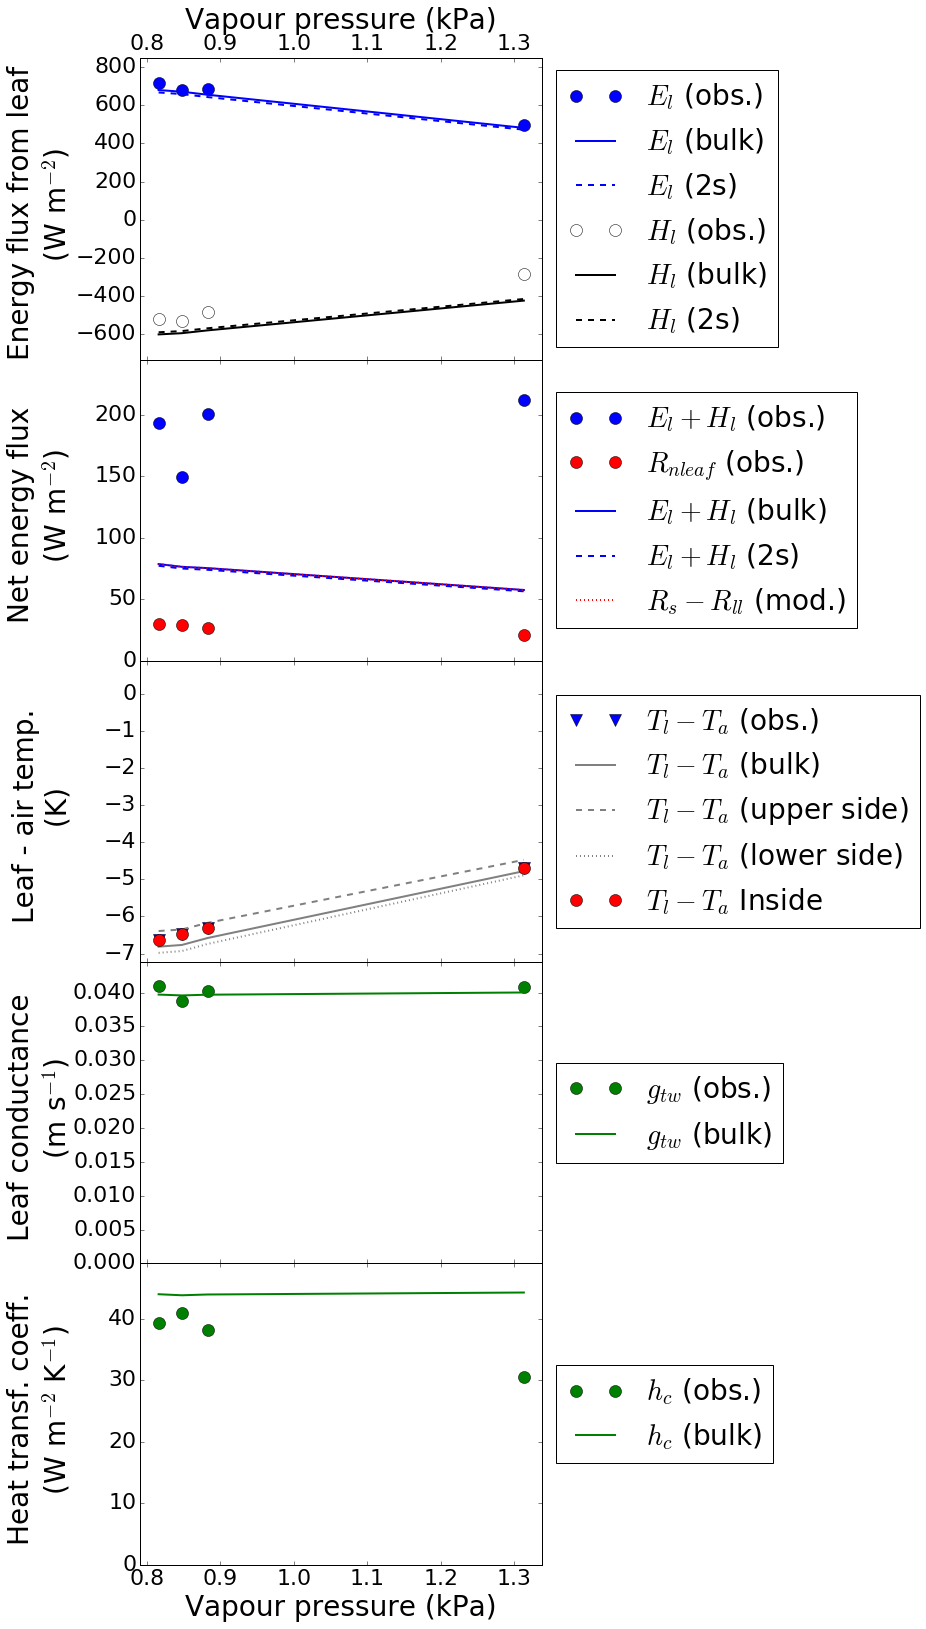

In [26]:
vdict = cdict.copy()
vdict[a_s] = 1
vdict[L_l] = 0.03
vdict[P_a] = 101325.
vdict[R_s] = 0
vdict[Re_c] = 3000.
vdict[g_sw] = 999
vdict[k_l] = 0.27  # between 0.268 and 0.573 according to Hays_1975_The_thermal.pdf
vdict[z_l] = 0.0005
ndict = {P_w_in: 'Pwin', T_l: 'T_leafTC', E_lmol: 'SensirionSLI'}
results_orig = fun_results(csv_data1, vdict1 = vdict, ndict1 = ndict, twosides=True, Pwinoffset=0)

#results1 = fun_results(csv_data1, ndict1 = {P_w_in: 'Pwin', T_l: 'T_leafTC', E_lmol: 'SensirionSLI', })
results1 = results_orig.copy()
list_vars = ['R_s', 'P_wa', 'T_a', 'v_w', 'g_sw']
for var1 in list_vars:
    print var1 + ' = (' + str(min(results1[var1])) + ', ' + str(max(results1[var1])) + ') ' + str(udict[eval(var1)]/eval(var1))
fun_plot_TN(results1, varname1 = 'P_wa', axeslabel1 = 'Vapour pressure (kPa)', xfac = 1/1000., fsize = 14,  alltemps = [('T_leafTC', 'Inside', 'o')], Emods = [('E_l', '(bulk)', '-'), ('2s_E_l', '(2s)', '--')], Hmods = [('H_l', '(bulk)', '-'), ('2s_H_l', '(2s)', '--')], Tmods = [('T_l', '(bulk)', '-'), ('2s_T_lu', '(upper side)', '--'), ('2s_T_ll', '(lower side)', ':')])

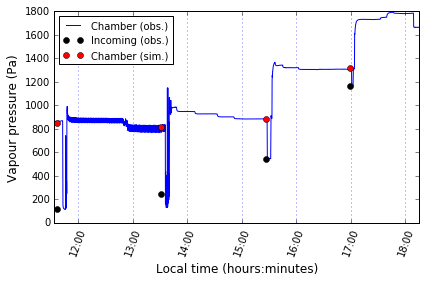

In [27]:
xdata = [li_data1['HHMMSS'], results1['lc_time'], results1['lc_time']]
ydata = [li_data1['Pwa'], results1['P_w_in'], results1['P_wa']]
ylabel1 = 'Vapour pressure (Pa)'
ynames1 = ['Chamber (obs.)', 'Incoming (obs.)', 'Chamber (sim.)']
yformats = ['b-', 'ko', 'ro']
fname1 = path_figs + 'Pwa_tseries.pdf'
fun_plottime_explicit(xdata, ydata, ylabel1, ynames1 = ynames1, yformats = yformats, fname = fname1, dpi = 100)

In the above plot, the blue line represents the continous measurements of the LI-6400XT, which were periodically switched between incoming and outgoing air. The blue dots represent the values for the incoming air, as extracted from the blue line, while the red dots represent the calculated values for the outgoing air. Correspondence between the red dots and the blue line suggests that the vapour pressure of the outgoing air was correctly simulated.

# Experiments in the dark

## Only filter paper

In [28]:
fname = 'exp_maxgs1.csv'
lc_data_orig = fun_read_csv(fname)
lc_data = lc_data_orig.copy()
lc_data['water_flow_avg'] = -lc_data_orig['water_flow_avg'] # Making flow positive
lc_data_orig = lc_data.copy()

lc_time,T_in1,T_in2,T_wall_in,T_wall_out,T_outside,T_outside_PT,T_chamber,T_leaf1,T_leaf2,T_leaf_in,Wind,T_dew,Air_inflow,Air_outflow,nr_time,T_leaf_IR,V_leaf_IR,sens_timefirst,sens_timelast,water_flow_avg,water_flow_std,water_flow_n,pow_timefirst,pow_timelast,fan_power_avg,fan_power_std,fan_power_n,Comment...................................................
TS,K,K,K,K,K,Deg C,K,K,K,K,m/s,degC,SLPM,SLPM,TS,Deg C,mV,,,ul/min,ul/min,ul/min,TS,TS,W,W,,
2014-03-05 15:15:18,16.23,16.35,22.73,22.76,22.75,23.58,22.70,20.83,21.22,NaN,4.943,-17.90,5.051,2.278,2014-03-05 15:15:19,15.54,-0.2384,2014-03-05 15:15:07,2014-03-05 15:15:17,-17.19,0.2266,95,2014-03-05 15:14:22,2014-03-05 15:15:21,1.407,2.220e-16,54,"lower Tdew, upwind CTA"
2014-03-05 15:32:02,16.25,16.36,22.81,22.85,22.83,23.70,22.77,20.99,21.34,NaN,5.275,-10.07,5.046,2.248,2014-03-05 15:32:01,15.86,-0.2277,2014-03-05 15:31:53,2014-03-05 15:32:03,-16.54,0.3207,100,2014-03-05 15:31:04,2014-03-05 15:32:03,1.407,2.220e-16,54,"higher Tdew, upwind CTA"
2014-03-05 16:08:45,16.24,16.36,22.86,23.19,23.19,24.07,22.82,20.98,21.41,17.25,5.329,-5.019,5.357,2.387,2014-03-05 16:08:45,15.84,-0.2283,2014-03-05 16:08:36,2014-03-05 16:08:45,-15.94,0.1731,100,2014-03-05 16:07:47,2014-03-05 16:08:46,1.407,0.0000,55,"sun has come out, outside wall suddenly started warming, rest unaffected"
2014-03-05 16:54:32,16.23,16.35,23.08,23.06,23.01,23.70,23.05,21.45,21.74,17.78,5.252,0.08289,5.193,2.409,2014-03-05 16:54:33,16.50,-0.2055,2014-03-05 16:54:25,2014-03-05 16:54:35,-15.02,0.2545,100,2014-03-05 16:53:36,2014-03-05 16:54:35,1.406,0.0000,54,
2014-03-06 10:35:50,15.87,15.97,21.86,21.81,21.79,22.57,21.83,20.06,20.50,16.32,5.356,0.09190,5.265,2.401,2014-03-06 10:35:53,16.65,-0.2004,2014-03-06 10:35:43,2014-03-06 10:35:53,-16.51,0.1232,100,2014-03-06 10:34:54,2014-03-06 10:35:53,1.412,0.0003413,52,
2014-03-06 11:11:22,15.60,15.69,21.72,21.77,21.72,22.53,21.68,20.13,20.50,16.78,5.455,5.125,5.957,2.635,2014-03-06 11:11:24,17.11,-0.1843,2014-03-06 11:11:06,2014-03-06 11:11:16,-14.94,0.1902,100,2014-03-06 11:10:25,2014-03-06 11:11:24,1.412,0.0000,54,
2014-03-06 12:54:16,15.45,15.54,21.74,21.77,21.73,22.41,21.69,20.35,20.74,17.71,5.360,10.21,6.529,2.843,2014-03-06 12:54:17,17.96,-0.1545,2014-03-06 12:54:10,2014-03-06 12:54:18,-12.30,0.1152,80,2014-03-06 12:53:18,2014-03-06 12:54:17,1.412,0.0000,55,
2014-03-06 13:58:02,15.89,15.99,21.95,21.93,21.92,22.69,21.92,20.20,20.57,16.46,5.451,-5.014,5.410,2.442,2014-03-06 13:58:01,16.46,-0.2069,2014-03-06 13:57:52,2014-03-06 13:58:02,-15.03,0.1793,100,2014-03-06 13:57:04,2014-03-06 13:58:03,1.412,0.0000,54,
2014-03-06 14:55:11,15.26,15.32,22.22,22.21,22.19,22.93,22.24,20.24,21.08,18.01,0.8222,10.21,7.830,3.616,2014-03-06 14:55:10,17.47,-0.1719,2014-03-06 14:55:02,2014-03-06 14:55:12,-6.361,0.1421,100,2014-03-06 14:54:13,2014-03-06 14:55:12,1.412,0.0000,54,low wind speed


In [29]:
pos_Tdew = [0..7]
pos_vw = [8..13]
pos_vw_orig = pos_vw[:]
pos_Tdew_orig = pos_Tdew[:]

In [30]:
vdict = cdict.copy()
vdict[a_s] = 1
vdict[L_l] = 0.03
vdict[P_a] = 101325.
vdict[R_s] = 0
vdict[Re_c] = 3000.
vdict[g_sw] = 999  # Non-limiting
vdict[k_l] = 0.27  # between 0.268 and 0.573 according to Hays_1975_The_thermal.pdf
vdict[z_l] = 0.0005
results_orig = fun_results(lc_data, vdict1 = vdict, twosides=True)

<p><span style="color: #ff0000;">Note that the filter paper had dried out on the edges during the first part experiment. Only the last few data points of the Tdew variation were better, when the water reservoir was elevated. The wind variation should be fine.<br /></span></p>

### Varying wind speed

R_s = (0.0, 0.0) joule/(R_s*meter^2*second)
P_wa = (1200.40416881, 1342.46062459) pascal/P_wa
T_a = (295.35, 295.61) kelvin/T_a
v_w = (0.8222, 5.468) meter/(second*v_w)
g_sw = (999.0, 999.0) meter/(g_sw*second)


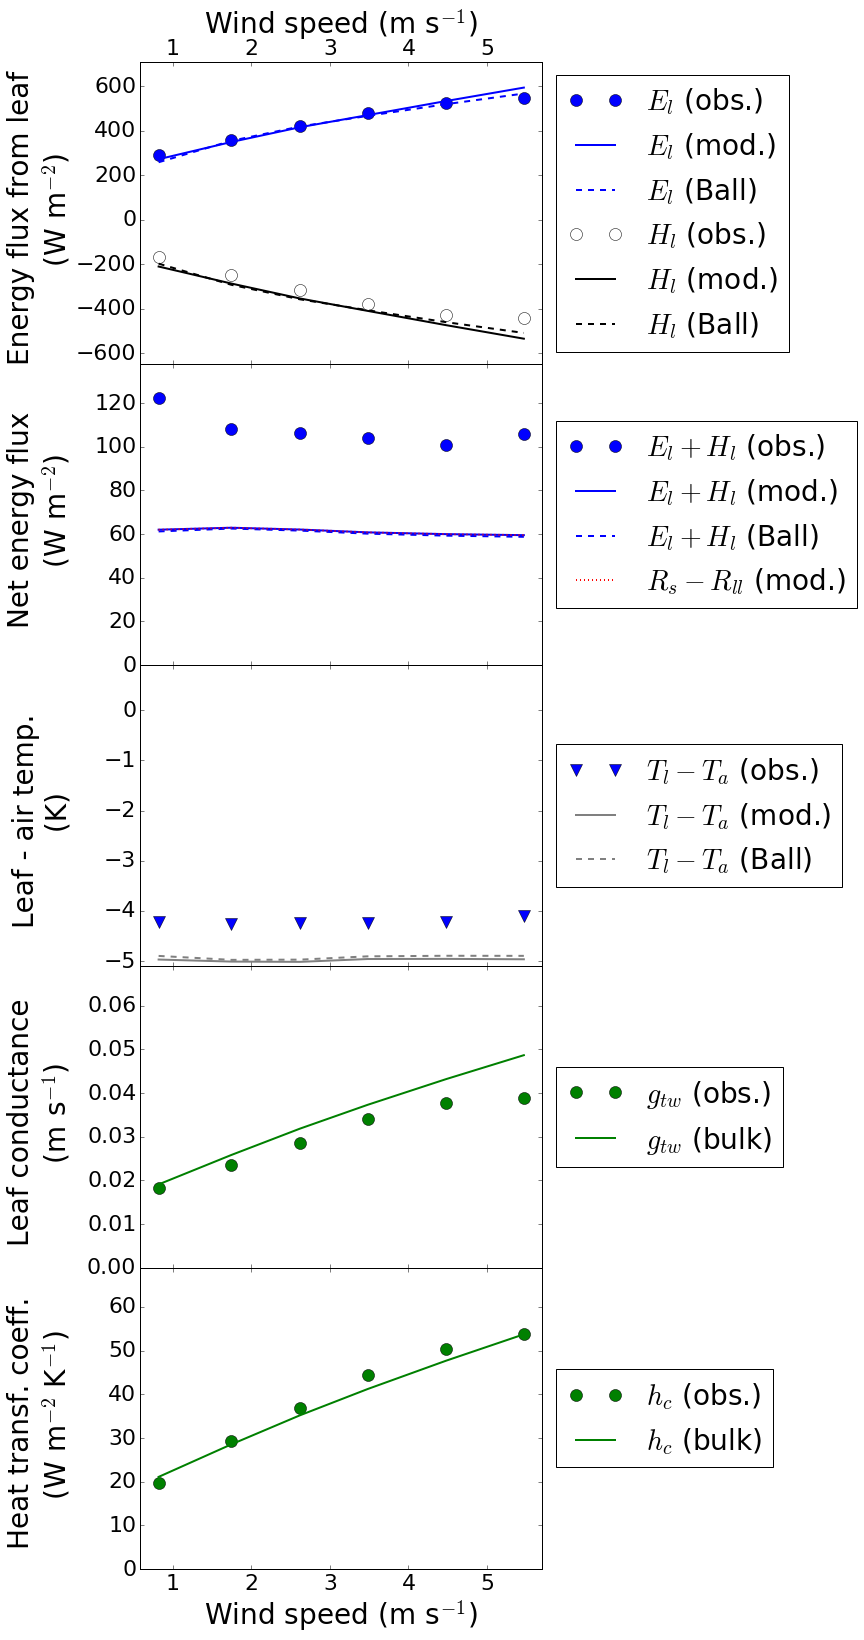

In [31]:
results1 = results_orig[pos_vw_orig]
list_vars = ['R_s', 'P_wa', 'T_a', 'v_w', 'g_sw']
for var1 in list_vars:
    print var1 + ' = (' + str(min(results1[var1])) + ', ' + str(max(results1[var1])) + ') ' + str(udict[eval(var1)]/eval(var1))
fun_plot_TN(results1, Emods = [('E_l', '(mod.)', '-'), ('El_ball', '(Ball)', '--')], Hmods = [('H_l', '(mod.)', '-'), ('Hl_ball', '(Ball)', '--')], Tmods = [('T_l', '(mod.)', '-'), ('Tl_ball', '(Ball)', '--')], alltemps = False, fname = '/home/sschyman/Documents/papers/leaf-windtunnel/figures/maxgs_vw_Ball')

### Calibrated thermal conductivity, Fig. 9a in Schymanski et al. (2016, HESSD)

R_s = (0.0, 0.0) joule/(R_s*meter^2*second)
P_wa = (1200.40416881, 1342.46062459) pascal/P_wa
T_a = (295.35, 295.61) kelvin/T_a
v_w = (0.8222, 5.468) meter/(second*v_w)
g_sw = (999.0, 999.0) meter/(g_sw*second)


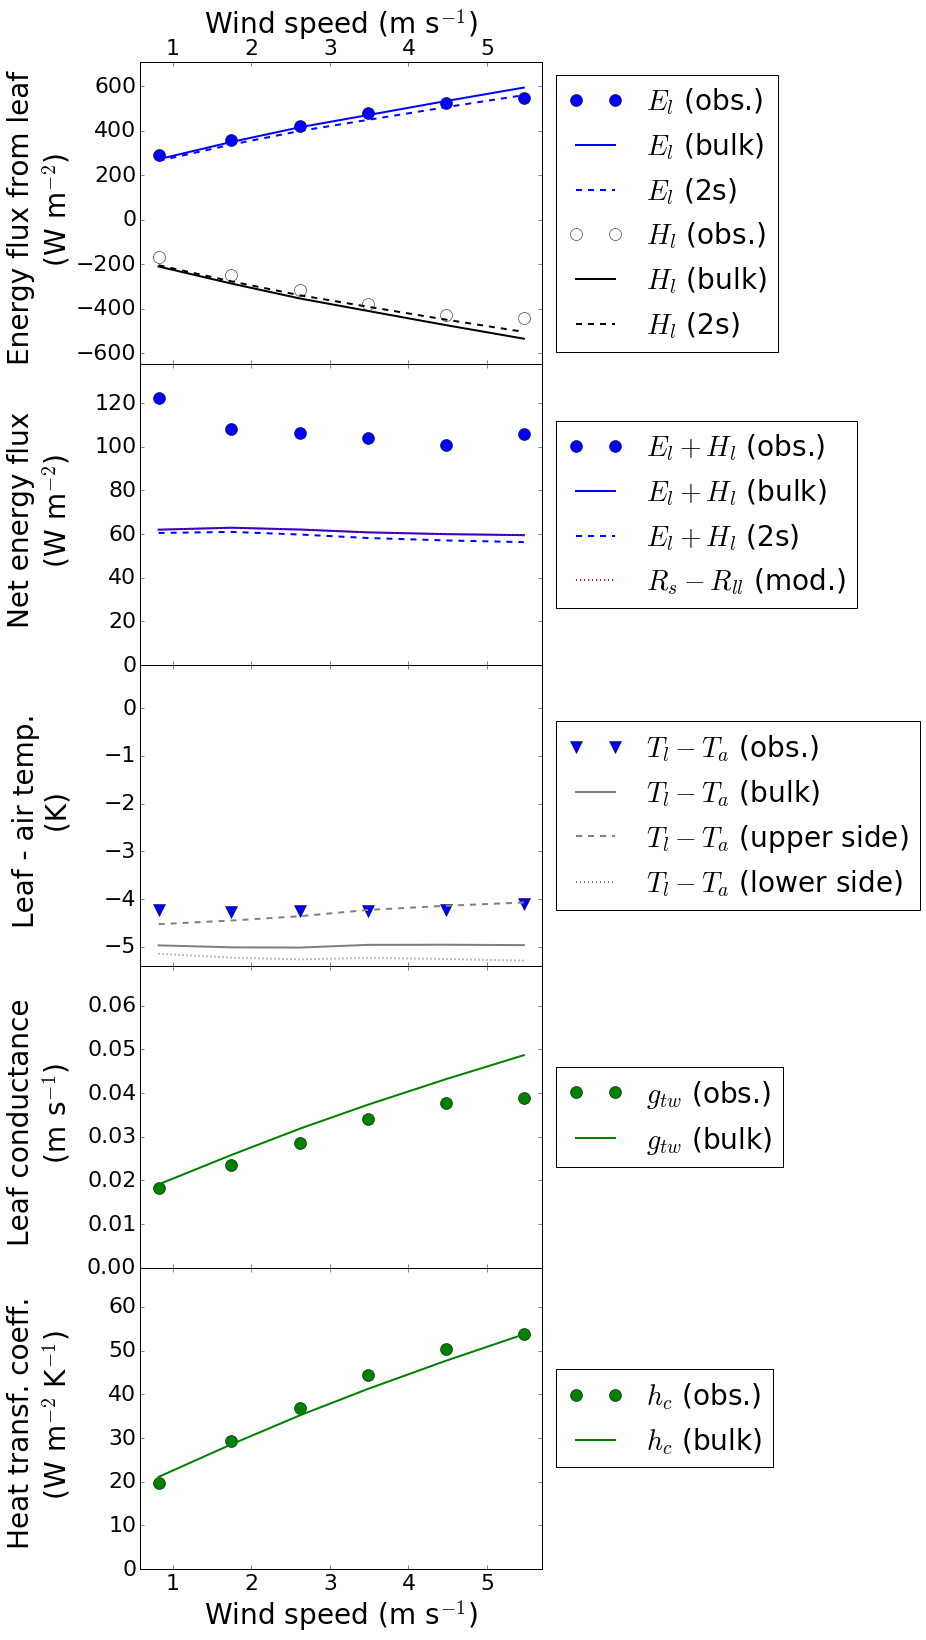

In [32]:
vdict = cdict.copy()
vdict[a_s] = 1
vdict[L_l] = 0.03
vdict[P_a] = 101325.
vdict[R_s] = 0
vdict[Re_c] = 3000.
vdict[g_sw] = 999
vdict[k_l] = 0.1  # between 0.268 and 0.573 according to Hays_1975_The_thermal.pdf
vdict[z_l] = 0.0005

results_orig = fun_results(lc_data, vdict1 = vdict, twosides=True)

results1 = results_orig[pos_vw_orig]
list_vars = ['R_s', 'P_wa', 'T_a', 'v_w', 'g_sw']
for var1 in list_vars:
    print var1 + ' = (' + str(min(results1[var1])) + ', ' + str(max(results1[var1])) + ') ' + str(udict[eval(var1)]/eval(var1))
fname = path_figs + 'maxgs_vw_kl1_2s_all.eps'
fun_plot_TN(results1, varname1 = 'v_w', axeslabel1 = 'Wind speed (m s$^{-1}$)', fsize = 14,  alltemps = False, \
        Emods = [('E_l', '(bulk)', '-'), ('2s_E_l', '(2s)', '--')], Hmods = [('H_l', '(bulk)', '-'), ('2s_H_l', '(2s)', '--')], \
        Tmods = [('T_l', '(bulk)', '-'), ('2s_T_lu', '(upper side)', '--'), ('2s_T_ll', '(lower side)', ':')], dpi1=50, fname=fname)

## Black foil, maxgs, Fig. 9b in Schymanski et al. (2016, HESSD)

In [33]:
fname = 'exp_maxgs_black_Tdew.csv'
lc_data_orig = fun_read_csv(fname, lc_timepos = [0, 15, 24, 25, 29, 30])
lc_data = lc_data_orig.copy()
lc_data['water_flow_avg'] = -lc_data_orig['water_flow_avg'] # Making flow positive
lc_data_orig = lc_data.copy()

lc_time,T_in1,T_in2,T_wall_in,T_wall_out,T_outside,T_outside_PT,T_chamber,T_leaf1,T_leaf2,T_leaf_in,Wind,T_dew,Air_inflow,Air_outflow,nr_time,T_leaf_IR,V_leaf_IR,Rn_above_leaf,Rn_below_leaf,Rn_beside_leaf,RnV_above_leaf,RnV_below_leaf,RnV_beside_leaf,sens_timefirst,sens_timelast,water_flow_avg,water_flow_std,water_flow_n,pow_timefirst,pow_timelast,fan_power_avg,fan_power_std,fan_power_n,Comment...................................................
TS,K,K,K,K,K,Deg C,K,K,K,K,m/s,degC,SLPM,SLPM,TS,Deg C,mV,W/m^2,W/m^2,W/m^2,mV,mV,mV,,,ul/min,ul/min,ul/min,TS,TS,W,W,,
2014-03-19 16:12:55,26.47,26.31,22.72,22.66,22.50,23.14,22.73,20.22,21.84,16.09,1.000,-10.07,3.939,2.150,2014-03-19 16:12:57,15.60,-0.2363,18.54,-19.70,-7.710,-0.02218,0.02048,0.009957,2014-03-19 16:12:20,2014-03-19 16:12:27,-9.747,0.1542,100,2014-03-19 16:11:56,2014-03-19 16:12:55,0.06452,0.00003198,54,"Black leaf only with filter paper, varying Tdew, cooler set to 20oC, humidifier T increased if necessary for steady state"
2014-03-19 17:25:05,26.42,26.27,22.64,22.68,22.53,23.38,22.62,20.05,21.76,15.74,1.040,-14.81,4.050,2.244,2014-03-19 17:25:06,15.31,-0.2463,19.15,-20.43,-8.228,-0.02292,0.02124,0.01063,2014-03-19 17:24:52,2014-03-19 17:24:59,-10.07,0.1254,100,2014-03-19 17:24:07,2014-03-19 17:25:06,0.06433,0.00001351,54,varying Tdew
2014-03-20 15:48:40,25.20,25.18,23.32,23.35,23.13,26.59,23.34,21.35,21.46,16.73,1.016,0.09124,7.228,3.876,2014-03-20 15:48:40,15.60,-0.2362,19.43,-18.45,26.66,-0.02325,0.01919,-0.03457,2014-03-20 15:48:19,2014-03-20 15:48:26,-9.434,0.09447,100,2014-03-20 15:47:40,2014-03-20 15:48:39,0.06381,0.00001725,55,varying Tdew
2014-03-20 17:07:40,25.19,25.18,23.40,23.43,23.34,26.75,23.42,21.19,21.30,16.15,1.034,-5.024,8.836,4.576,2014-03-20 17:07:40,14.96,-0.2582,21.20,-20.15,26.72,-0.02537,0.02095,-0.03465,2014-03-20 17:07:26,2014-03-20 17:07:33,-10.28,0.2422,100,2014-03-20 17:06:42,2014-03-20 17:07:40,0.06378,0.00002570,54,varying Tdew
2014-03-24 12:32:10,26.41,26.29,22.33,22.38,22.29,25.77,22.35,19.04,21.25,16.24,1.018,-5.015,3.558,2.085,2014-03-24 12:32:12,16.24,-0.2142,17.04,-16.80,-0.4545,-0.02039,0.01747,0.0005564,2014-03-24 12:32:03,2014-03-24 12:32:10,-8.945,0.1869,100,2014-03-24 12:31:10,2014-03-24 12:32:09,0.06426,0.00001137,55,varying Tdew
2014-03-24 14:11:58,24.02,24.01,22.56,22.53,22.45,25.85,22.58,19.56,21.55,17.00,1.009,5.115,8.549,4.539,2014-03-24 14:11:59,16.82,-0.1943,15.65,-15.06,-0.7787,-0.01872,0.01566,0.0009764,2014-03-24 14:11:50,2014-03-24 14:11:57,-8.092,0.1858,100,2014-03-24 14:10:58,2014-03-24 14:11:57,0.06428,0.00001451,55,varying Tdew
2014-03-24 14:43:04,24.25,24.23,22.57,22.58,22.47,25.93,22.59,20.20,21.78,18.19,1.012,10.21,5.554,3.175,2014-03-24 14:43:06,17.91,-0.1562,12.55,-11.98,-0.1198,-0.01502,0.01246,0.0001227,2014-03-24 14:42:49,2014-03-24 14:42:56,-6.581,0.1051,100,2014-03-24 14:42:05,2014-03-24 14:43:04,0.06431,0.00001674,54,varying Tdew
2014-03-24 16:24:34,23.23,23.19,22.21,22.30,22.24,25.57,22.22,20.66,21.69,19.41,1.038,15.14,4.038,2.444,2014-03-24 16:24:33,19.09,-0.1145,7.638,-8.015,4.552,-0.009139,0.008339,-0.005931,2014-03-24 16:24:26,2014-03-24 16:24:33,-4.273,0.1099,100,2014-03-24 16:23:34,2014-03-24 16:24:33,0.06441,0.00001503,54,varying Tdew
2014-03-24 18:05:16,22.65,22.65,22.50,22.38,22.38,25.89,22.50,21.80,22.26,21.30,1.032,20.10,4.065,2.476,2014-03-24 18:05:19,20.79,-0.05258,3.647,-3.204,1.439,-0.004363,0.003339,-0.001896,2014-03-24 18:04:58,2014-03-24 18:05:05,-1.934,0.1372,100,2014-03-24 18:04:18,2014-03-24 18:05:17,0.06427,0.00001650,54,varying Tdew


R_s = (0.0, 0.0) joule/(R_s*meter^2*second)
P_wa = (466.848762265, 2221.34112236) pascal/P_wa
T_a = (295.37, 296.57) kelvin/T_a
v_w = (1.0, 1.04) meter/(second*v_w)
g_sw = (999.0, 999.0) meter/(g_sw*second)


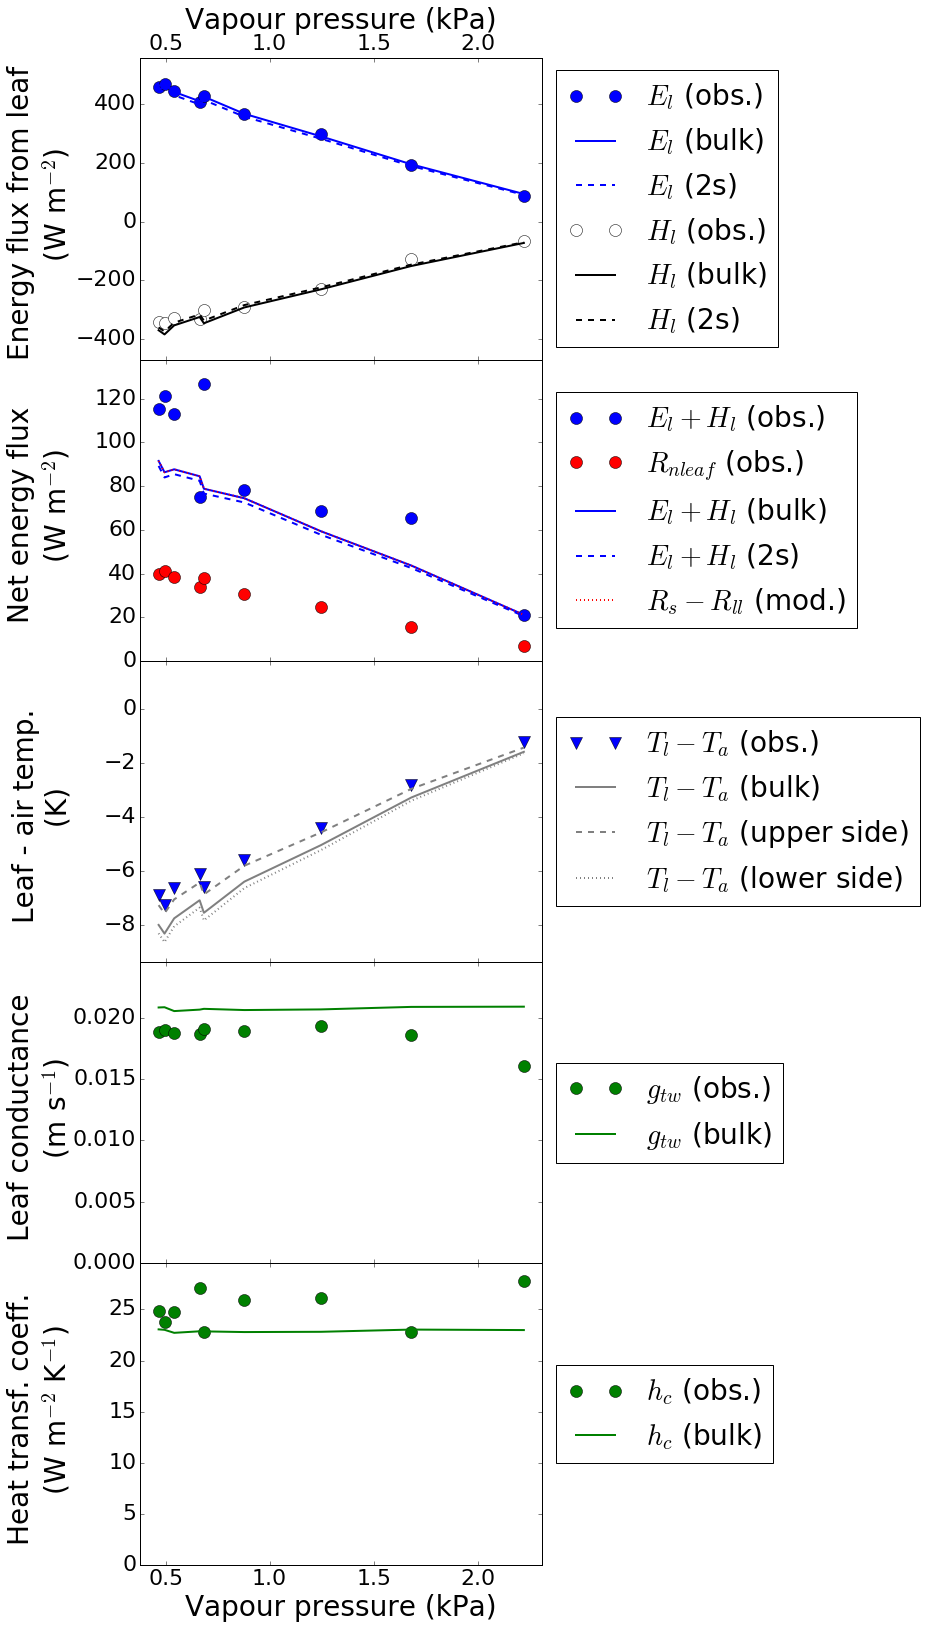

In [34]:
# Calibrated thermal conductivity
lc_data = lc_data_orig.copy()
vdict = cdict.copy()
vdict[a_s] = 1
vdict[L_l] = 0.03
vdict[P_a] = 101325.
vdict[R_s] = 0
vdict[Re_c] = 3000.
vdict[g_sw] = 999
vdict[k_l] = 0.1  # between 0.268 and 0.573 according to Hays_1975_The_thermal.pdf
vdict[z_l] = 0.0005

results_orig = fun_results(lc_data, vdict1 = vdict, twosides=True)

results1 = results_orig.copy()
list_vars = ['R_s', 'P_wa', 'T_a', 'v_w', 'g_sw']
for var1 in list_vars:
    print var1 + ' = (' + str(min(results1[var1])) + ', ' + str(max(results1[var1])) + ') ' + str(udict[eval(var1)]/eval(var1))
fname = path_figs + 'maxgs_Pwa_kl1_2s_all.eps'
fun_plot_TN(results1, varname1 = 'P_wa', axeslabel1 ='Vapour pressure (kPa)', xfac = 1/1000., fsize = 14,  alltemps = False, \
        Emods = [('E_l', '(bulk)', '-'), ('2s_E_l', '(2s)', '--')], Hmods = [('H_l', '(bulk)', '-'), ('2s_H_l', '(2s)', '--')], \
        Tmods = [('T_l', '(bulk)', '-'), ('2s_T_lu', '(upper side)', '--'), ('2s_T_ll', '(lower side)', ':')], dpi1=50, fname=fname)

<p><span style="color: #ff0000;">If the effective leaf thermal conductivity of the artificial leaf is only 30% of that of real leaves, the upper side of the leaf could have similar temperatures as the TC readings, without significant change to the fluxes.<br /></span></p>

## Perforated foil 63_1, Figure A4a in Schymanski et al. (2016, HESSD)

lc_time,T_in1,T_in2,T_wall_in,T_wall_out,T_outside,T_outside_PT,T_chamber,T_leaf1,T_leaf2,T_leaf_in,Wind,T_dew,Air_inflow,Air_outflow,nr_time,T_leaf_IR,V_leaf_IR,sens_timefirst,sens_timelast,water_flow_avg,water_flow_std,water_flow_n,pow_timefirst,pow_timelast,fan_power_avg,fan_power_std,fan_power_n,Comment...................................................
TS,K,K,K,K,K,Deg C,K,K,K,K,m/s,degC,SLPM,SLPM,TS,Deg C,mV,,,ul/min,ul/min,ul/min,TS,TS,W,W,,
2014-03-08 13:57:52,15.27,15.34,22.01,22.01,21.99,22.73,21.95,21.49,21.64,19.42,5.559,10.21,7.192,3.081,2014-03-08 13:57:50,20.46,-0.06480,2014-03-08 13:57:45,2014-03-08 13:57:52,-8.900,0.09177,100,2014-03-08 13:56:53,2014-03-08 13:57:52,1.412,0.0000,54,varying wind speed
2014-03-08 14:22:57,15.27,15.33,21.98,22.05,22.02,22.85,21.96,21.44,21.58,19.34,4.740,10.21,7.292,3.095,2014-03-08 14:22:58,20.41,-0.06680,2014-03-08 14:22:52,2014-03-08 14:22:59,-8.492,0.1071,100,2014-03-08 14:22:01,2014-03-08 14:22:59,1.411,0.0000,54,varying wind speed
2014-03-08 15:01:24,15.38,15.44,22.05,22.08,22.06,22.81,22.09,21.47,21.64,19.37,3.887,10.21,7.042,3.018,2014-03-08 15:01:25,20.46,-0.06480,2014-03-08 15:01:19,2014-03-08 15:01:26,-8.020,0.08356,100,2014-03-08 15:00:28,2014-03-08 15:01:27,1.378,0.0004714,54,varying wind speed
2014-03-08 15:30:25,15.36,15.43,22.08,22.07,22.03,22.81,22.10,21.40,21.62,19.30,3.192,10.21,7.146,2.948,2014-03-08 15:30:23,20.41,-0.06679,2014-03-08 15:30:18,2014-03-08 15:30:25,-7.362,0.1076,100,2014-03-08 15:29:27,2014-03-08 15:30:25,1.366,0.0005000,54,varying wind speed
2014-03-08 16:24:17,15.27,15.36,22.05,22.08,22.02,22.93,22.07,21.26,21.53,19.16,2.480,10.21,7.420,3.026,2014-03-08 16:24:16,20.35,-0.06879,2014-03-08 16:24:10,2014-03-08 16:24:17,-6.647,0.1155,100,2014-03-08 16:23:18,2014-03-08 16:24:17,1.378,0.0000,55,varying wind speed
2014-03-08 16:40:37,15.25,15.33,22.09,22.08,22.03,22.89,22.10,21.09,21.42,18.99,1.744,10.21,7.585,3.110,2014-03-08 16:40:38,20.30,-0.07079,2014-03-08 16:24:19,2014-03-08 16:24:25,-5.803,0.1403,100,2014-03-08 16:39:40,2014-03-08 16:40:39,1.378,0.0000,55,varying wind speed
2014-03-08 17:13:26,15.13,15.20,22.09,22.12,22.06,22.85,22.09,20.75,21.13,18.74,0.8469,10.20,7.960,3.221,2014-03-08 17:13:29,20.13,-0.07677,2014-03-08 17:13:21,2014-03-08 17:13:28,-4.810,0.07704,100,2014-03-08 17:12:30,2014-03-08 17:13:29,1.378,0.0000,54,varying wind speed


R_s = (0.0, 0.0) joule/(R_s*meter^2*second)
P_wa = (1173.97846865, 1252.74896325) pascal/P_wa
T_a = (295.1, 295.25) kelvin/T_a
v_w = (0.8469, 5.559) meter/(second*v_w)
g_sw = (0.05, 0.05) meter/(g_sw*second)


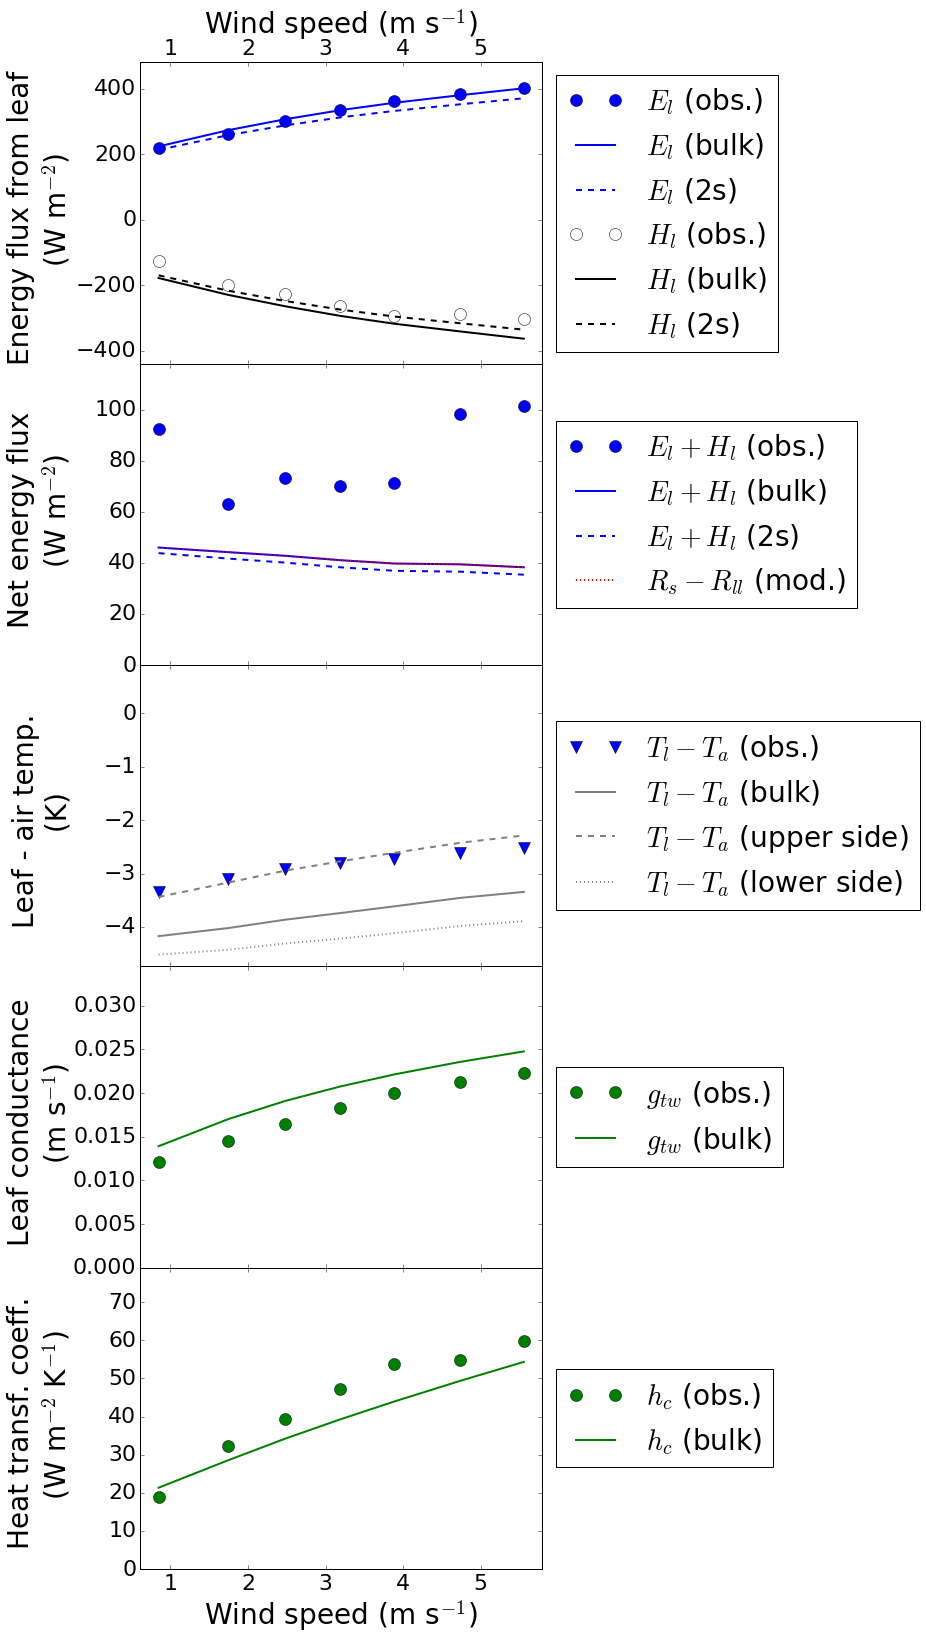

In [35]:
fname = 'exp_63_1_thin.csv'
lc_data_orig = fun_read_csv(fname)
lc_data = lc_data_orig.copy()
lc_data['water_flow_avg'] = -lc_data_orig['water_flow_avg'] # Making flow positive
lc_data_orig = lc_data.copy()

# Calibrated k_l
vdict = cdict.copy()
vdict[a_s] = 1
vdict[L_l] = 0.03
vdict[P_a] = 101325.
vdict[R_s] = 0
vdict[Re_c] = 3000.
vdict[k_l] = 0.03  # between 0.268 and 0.573 according to Hays_1975_The_thermal.pdf
vdict[z_l] = 0.00035  # Thin leaf
vdict[g_sw] = 0.05   # Tuned
results_orig = fun_results(lc_data, vdict1 = vdict, twosides=True)
results1 = results_orig.copy()
list_vars = ['R_s', 'P_wa', 'T_a', 'v_w', 'g_sw']
for var1 in list_vars:
    print var1 + ' = (' + str(min(results1[var1])) + ', ' + str(max(results1[var1])) + ') ' + str(udict[eval(var1)]/eval(var1))
fname = path_figs + '63_vw_kl03_2s_all.eps'
fun_plot_TN(results1, varname1 = 'v_w', axeslabel1 = 'Wind speed (m s$^{-1}$)', fsize = 14,  alltemps = False, \
        Emods = [('E_l', '(bulk)', '-'), ('2s_E_l', '(2s)', '--')], Hmods = [('H_l', '(bulk)', '-'), ('2s_H_l', '(2s)', '--')], \
        Tmods = [('T_l', '(bulk)', '-'), ('2s_T_lu', '(upper side)', '--'), ('2s_T_ll', '(lower side)', ':')], dpi1=50, fname=fname)

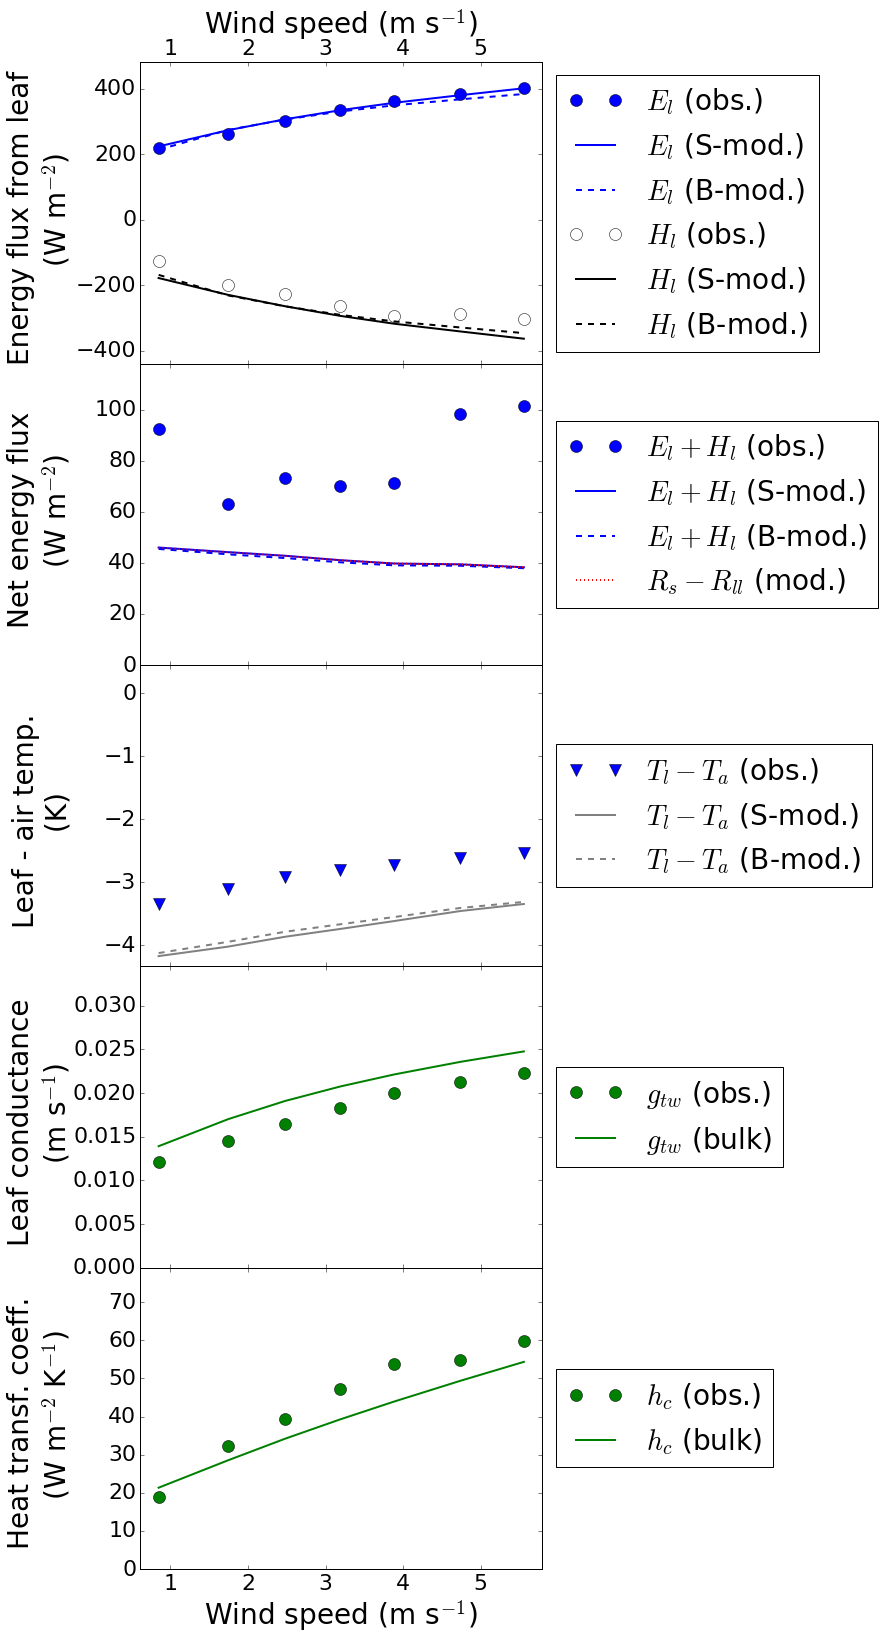

In [36]:
fun_plot_TN(results1, fsize = 14,  alltemps = False, Emods = [('E_l', '(S-mod.)', '-'), ('El_ball', '(B-mod.)', '--')], Hmods = [('H_l', '(S-mod.)', '-'), ('Hl_ball', '(B-mod.)', '--')], Tmods = [('T_l', '(S-mod.)', '-'), ('Tl_ball', '(B-mod.)', '--')])

## Black foil, 35.4 holes/mm2, Figure A5a in Schymanski et al. (2016, HESSD)
In the below experiments, we also measured chamber air temperature just after the leaf, in order to assess the uncertainty in $H_l$ due to leaks in this area, given that the measured outflow is only half of the measured inflow.

In [37]:
fname = 'exp_35_4_Tdew.csv'
lc_data_orig = fun_read_csv(fname, lc_timepos = [0, 16, 25, 26, 30, 31])
lc_data = lc_data_orig.copy()
lc_data['water_flow_avg'] = -lc_data_orig['water_flow_avg'] # Making flow positive
lc_data_orig = lc_data.copy()
lc_data_35_Pwa = lc_data.copy()

lc_time,T_in1,T_in2,T_wall_in,T_wall_out,T_outside,T_outside_PT,T_chamber,T_chamber1,T_leaf1,T_leaf2,T_leaf_in,Wind,T_dew,Air_inflow,Air_outflow,nr_time,T_leaf_IR,V_leaf_IR,Rn_above_leaf,Rn_below_leaf,Rn_beside_leaf,RnV_above_leaf,RnV_below_leaf,RnV_beside_leaf,sens_timefirst,sens_timelast,water_flow_avg,water_flow_std,water_flow_n,pow_timefirst,pow_timelast,fan_power_avg,fan_power_std,fan_power_n,Comment...................................................
TS,K,K,K,K,K,Deg C,K,K,K,K,K,m/s,degC,SLPM,SLPM,TS,Deg C,mV,W/m^2,W/m^2,W/m^2,mV,mV,mV,,,ul/min,ul/min,ul/min,TS,TS,W,W,,
2014-03-25 12:39:34,23.98,23.97,22.56,22.52,22.50,25.93,22.58,21.99,19.92,21.18,16.53,0.9999,-19.32,9.052,4.451,2014-03-25 12:39:35,19.36,-0.1045,16.74,-6.927,-26.00,-0.02004,0.007208,0.03366,2014-03-25 12:39:21,2014-03-25 12:39:28,-8.233,0.1577,100,2014-03-25 12:38:37,2014-03-25 12:39:35,0.06427,0.00001266,54,"Black leaf, silver perforated alu (35.4-1), varying Tdew"
2014-03-25 13:01:40,23.97,23.97,22.57,22.58,22.54,26.05,22.58,22.00,20.00,21.22,16.68,1.020,-14.97,8.490,4.180,2014-03-25 13:01:41,19.36,-0.1045,16.25,-6.859,-25.52,-0.01945,0.007137,0.03303,2014-03-25 13:01:22,2014-03-25 13:01:29,-7.859,0.3323,100,2014-03-25 13:00:39,2014-03-25 13:01:38,0.06428,0.00002267,55,varying Tdew
2014-03-25 14:07:31,23.91,23.91,22.58,22.59,22.59,26.10,22.57,22.04,20.10,21.26,16.88,1.021,-10.08,8.556,4.293,2014-03-25 14:07:31,19.53,-0.09854,15.18,-6.506,-24.44,-0.01817,0.006771,0.03163,2014-03-25 14:07:11,2014-03-25 14:07:18,-7.807,0.1403,100,2014-03-25 14:06:32,2014-03-25 14:07:31,0.06429,0.00001291,54,varying Tdew
2014-03-25 16:30:31,24.25,24.24,22.76,22.68,22.67,26.14,22.77,22.26,20.43,21.52,17.38,1.028,-5.017,7.524,3.821,2014-03-25 16:30:34,19.81,-0.08857,14.46,-6.187,-22.65,-0.01730,0.006439,0.02931,2014-03-25 16:30:18,2014-03-25 16:30:25,-7.440,0.07817,100,2014-03-25 16:29:33,2014-03-25 16:30:32,0.06417,0.00001307,54,varying Tdew
2014-03-25 16:48:46,24.28,24.23,22.73,22.73,22.72,26.02,22.75,22.25,20.57,21.61,17.81,1.019,0.08945,6.557,3.387,2014-03-25 16:48:48,19.92,-0.08459,13.34,-5.753,-20.79,-0.01596,0.005988,0.02690,2014-03-25 16:48:26,2014-03-25 16:48:33,-6.759,0.2183,100,2014-03-25 16:47:46,2014-03-25 16:48:45,0.06423,0.00002734,55,varying Tdew
2014-03-25 17:08:19,24.24,24.21,22.75,22.67,22.68,26.02,22.74,22.34,20.86,21.74,18.41,1.026,5.120,5.555,2.939,2014-03-25 17:08:22,20.11,-0.07734,11.71,-5.082,-18.50,-0.01401,0.005290,0.02393,2014-03-25 17:08:08,2014-03-25 17:08:15,-5.926,0.1492,100,2014-03-25 17:07:21,2014-03-25 17:08:20,0.06411,0.00001511,55,varying Tdew
2014-03-25 17:33:07,24.16,24.14,22.79,22.74,22.69,26.06,22.80,22.46,21.25,21.97,19.27,1.016,10.21,4.554,2.509,2014-03-25 17:33:08,20.48,-0.06401,9.708,-4.205,-15.42,-0.01162,0.004379,0.01994,2014-03-25 17:32:52,2014-03-25 17:32:59,-5.070,0.1435,100,2014-03-25 17:32:06,2014-03-25 17:33:05,0.06434,0.00002586,55,varying Tdew
2014-03-25 18:20:04,23.97,23.93,22.78,22.77,22.75,26.06,22.79,22.53,21.71,22.21,20.36,1.040,15.16,3.047,1.719,2014-03-25 18:20:06,20.90,-0.04869,6.990,-2.973,-10.52,-0.008364,0.003099,0.01360,2014-03-25 18:19:53,2014-03-25 18:20:00,-3.535,0.2791,100,2014-03-25 18:19:05,2014-03-25 18:20:04,0.06408,0.00002733,55,varying Tdew


R_s = (0.0, 0.0) joule/(R_s*meter^2*second)
P_wa = (218.598991722, 1694.78883295) pascal/P_wa
T_a = (295.72, 295.95) kelvin/T_a
v_w = (0.9999, 1.04) meter/(second*v_w)
g_sw = (0.035, 0.035) meter/(g_sw*second)


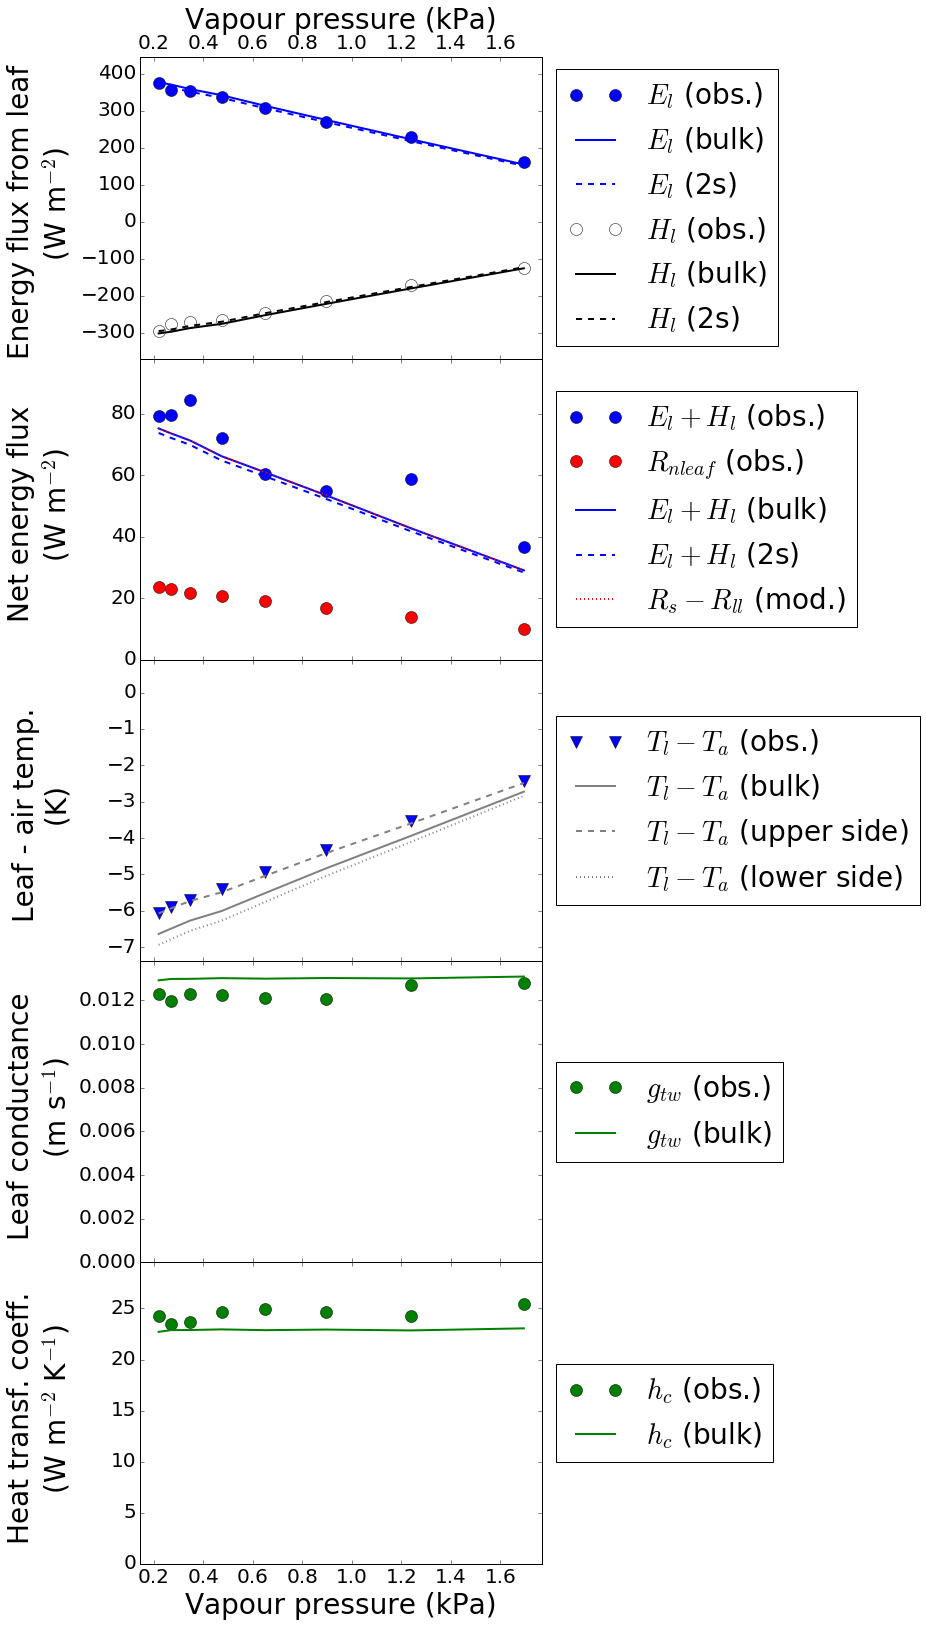

In [38]:
vdict = cdict.copy()
vdict[a_s] = 1
vdict[L_l] = 0.03
vdict[P_a] = 101325.
vdict[R_s] = 0
vdict[Re_c] = 3000.
vdict[k_l] = 0.1  # between 0.268 and 0.573 according to Hays_1975_The_thermal.pdf
vdict[z_l] = 0.0005
vdict[g_sw] = 0.035   # According to perforated_foils_LO: range 0.023-0.051
results_orig = fun_results(lc_data, vdict1 = vdict, twosides=True)
results1 = results_orig.copy()
results_35 = results_orig.copy()
list_vars = ['R_s', 'P_wa', 'T_a', 'v_w', 'g_sw']
for var1 in list_vars:
    print var1 + ' = (' + str(min(results1[var1])) + ', ' + str(max(results1[var1])) + ') ' + str(udict[eval(var1)]/eval(var1))
fname = path_figs + '35_Pwa_klcal_2s_all.eps'
fun_plot_TN(results1, varname1 = 'P_wa', axeslabel1 = 'Vapour pressure (kPa)', xfac = 1/1000., axfsize = 20,  alltemps = False, \
        Emods = [('E_l', '(bulk)', '-'), ('2s_E_l', '(2s)', '--')], Hmods = [('H_l', '(bulk)', '-'), ('2s_H_l', '(2s)', '--')], \
        Tmods = [('T_l', '(bulk)', '-'), ('2s_T_lu', '(upper side)', '--'), ('2s_T_ll', '(lower side)', ':')], fname=fname)

## 35.4 holes/mm2, varying wind speed,  Figure A4b in Schymanski et al. (2016, HESSD)
<p>$g_{sv}$-range according to perforated_foils_LO:</p>
<pre class="shrunk">min/max:
gsp: (0.043695677, 0.070854492)
gsw: (0.019652234, 0.027908623)
gsw_r0: (0.027980447, 0.04199113)
gsw_r0_S: (0.033073541, 0.051419344)
gsw_AO: (0.015633401, 0.02144536)

BUMP:
gsp: (0.030809233, 0.042032648)
gsw: (0.014939534, 0.019531313)
gsw_r0: (0.020606836, 0.027298812)
gsw_r0_S: (0.02390163, 0.031910311)
gsw_AO: (0.011958141, 0.015504949)</pre>

In [39]:
fname = 'exp_35_4_vw.csv'
lc_data_orig = fun_read_csv(fname, lc_timepos = [])
lc_data = lc_data_orig.copy()
lc_data['water_flow_avg'] = -lc_data_orig['water_flow_avg'] # Making flow positive
lc_data_orig = lc_data.copy()

lc_time,T_in1,T_in2,T_wall_in,T_wall_out,T_outside,T_outside_PT,T_chamber,T_chamber1,T_leaf1,T_leaf2,T_leaf_in,Wind,T_dew,Air_inflow,Air_outflow,nr_time,T_leaf_IR,V_leaf_IR,Rn_above_leaf,Rn_below_leaf,Rn_beside_leaf,RnV_above_leaf,RnV_below_leaf,RnV_beside_leaf,sens_timefirst,sens_timelast,water_flow_avg,water_flow_std,water_flow_n,pow_timefirst,pow_timelast,fan_power_avg,fan_power_std,fan_power_n,Comment...................................................
TS,K,K,K,K,K,Deg C,K,K,K,K,K,m/s,degC,SLPM,SLPM,TS,Deg C,mV,W/m^2,W/m^2,W/m^2,mV,mV,mV,,,ul/min,ul/min,ul/min,TS,TS,W,W,,
2014-03-27 11:22:28,15.30,15.41,21.98,21.97,21.88,25.24,22.00,21.67,20.29,21.07,18.41,0.8333,10.21,6.827,3.491,2014-03-27 11:22:29,20.30,-0.07058,9.835,-3.912,-13.66,-0.01177,0.004074,0.01766,2014-03-27 11:22:19,2014-03-27 11:22:26,-4.825,0.1412,100,2014-03-27 11:21:28,2014-03-27 11:22:27,1.195,0.0003885,54,"Black leaf, silver perforated alu (35.4-1), varying wind speed"
2014-03-27 13:01:58,15.54,15.65,22.22,22.26,22.22,25.53,22.22,21.95,20.72,21.46,18.72,1.313,10.21,6.427,3.324,2014-03-27 13:02:01,20.41,-0.06664,10.02,-3.833,-16.85,-0.01199,0.003993,0.02180,2014-03-27 13:01:48,2014-03-27 13:01:55,-5.543,0.1600,100,2014-03-27 13:00:59,2014-03-27 13:01:58,1.181,0.0004875,54,varying wind speed
2014-03-27 14:04:25,15.68,15.80,22.41,22.40,22.37,25.69,22.43,22.17,21.05,21.76,18.95,1.796,10.21,6.251,3.274,2014-03-27 14:04:23,20.36,-0.06849,10.02,-3.781,-17.83,-0.01198,0.003939,0.02307,2014-03-27 14:04:10,2014-03-27 14:04:17,-6.124,0.1336,100,2014-03-27 14:03:24,2014-03-27 14:04:23,1.185,0.0003885,54,varying wind speed
2014-03-27 15:55:10,15.74,15.85,22.40,22.42,22.36,25.61,22.42,22.18,21.22,21.85,19.06,2.299,10.21,6.140,3.202,2014-03-27 15:55:11,19.58,-0.09654,9.917,-3.843,-17.14,-0.01187,0.004003,0.02218,2014-03-27 15:55:01,2014-03-27 15:55:08,-6.583,0.1710,100,2014-03-27 15:54:09,2014-03-27 15:55:08,1.169,0.0004755,55,varying wind speed
2014-03-27 17:01:01,15.90,16.02,22.43,22.48,22.40,25.81,22.45,22.22,21.42,21.96,19.24,2.995,10.21,5.851,3.136,2014-03-27 17:01:03,20.03,-0.08036,8.408,-3.625,-16.34,-0.01006,0.003776,0.02114,2014-03-27 17:00:38,2014-03-27 17:00:48,-7.255,0.1174,100,2014-03-27 17:00:04,2014-03-27 17:01:03,1.144,0.0000,54,varying wind speed
2014-03-27 19:00:22,15.88,15.99,22.40,22.38,22.21,25.57,22.46,22.24,21.53,22.03,19.38,3.831,10.20,5.750,3.057,2014-03-27 19:00:26,19.20,-0.1106,8.123,-3.345,-14.00,-0.009719,0.003485,0.01811,2014-03-27 19:00:07,2014-03-27 19:00:17,-8.006,0.1148,100,2014-03-27 18:59:24,2014-03-27 19:00:23,1.155,0.0004130,55,varying wind speed
2014-03-28 10:08:04,15.46,15.57,21.81,21.91,21.85,25.20,21.85,21.67,20.98,21.44,18.93,3.804,10.20,6.147,3.245,2014-03-28 10:08:10,19.58,-0.09655,8.239,-2.960,-12.37,-0.009857,0.003085,0.01600,2014-03-28 10:07:52,2014-03-28 10:08:02,-7.736,0.1666,100,2014-03-28 10:07:07,2014-03-28 10:08:06,1.159,0.0001872,55,New day
2014-03-28 11:29:49,15.71,15.83,22.23,22.21,22.15,25.57,22.24,22.08,21.38,21.84,19.29,4.335,10.20,5.858,3.204,2014-03-28 11:29:51,19.47,-0.1005,8.058,-3.227,-12.36,-0.009641,0.003363,0.01599,2014-03-28 11:29:27,2014-03-28 11:29:37,-7.984,0.08737,100,2014-03-28 11:28:49,2014-03-28 11:29:48,1.174,0.0004692,55,New day
2014-03-28 13:47:28,15.80,15.90,22.35,22.28,22.21,25.57,22.31,22.16,21.54,21.99,19.46,5.102,10.20,5.858,3.131,2014-03-28 13:47:29,19.50,-0.09967,6.985,-3.328,-12.71,-0.008357,0.003468,0.01643,2014-03-28 13:47:18,2014-03-28 13:47:27,-8.505,0.1932,100,2014-03-28 13:46:29,2014-03-28 13:47:28,1.186,0.0004914,54,Reduced head difference (transpiration seemed low)


0.0420000000000000
R_s = (0.0, 0.0) joule/(R_s*meter^2*second)
P_wa = (1187.38813505, 1278.34796382) pascal/P_wa
T_a = (295.0, 296.53) kelvin/T_a
v_w = (0.8333, 5.102) meter/(second*v_w)
g_sw = (0.042, 0.042) meter/(g_sw*second)


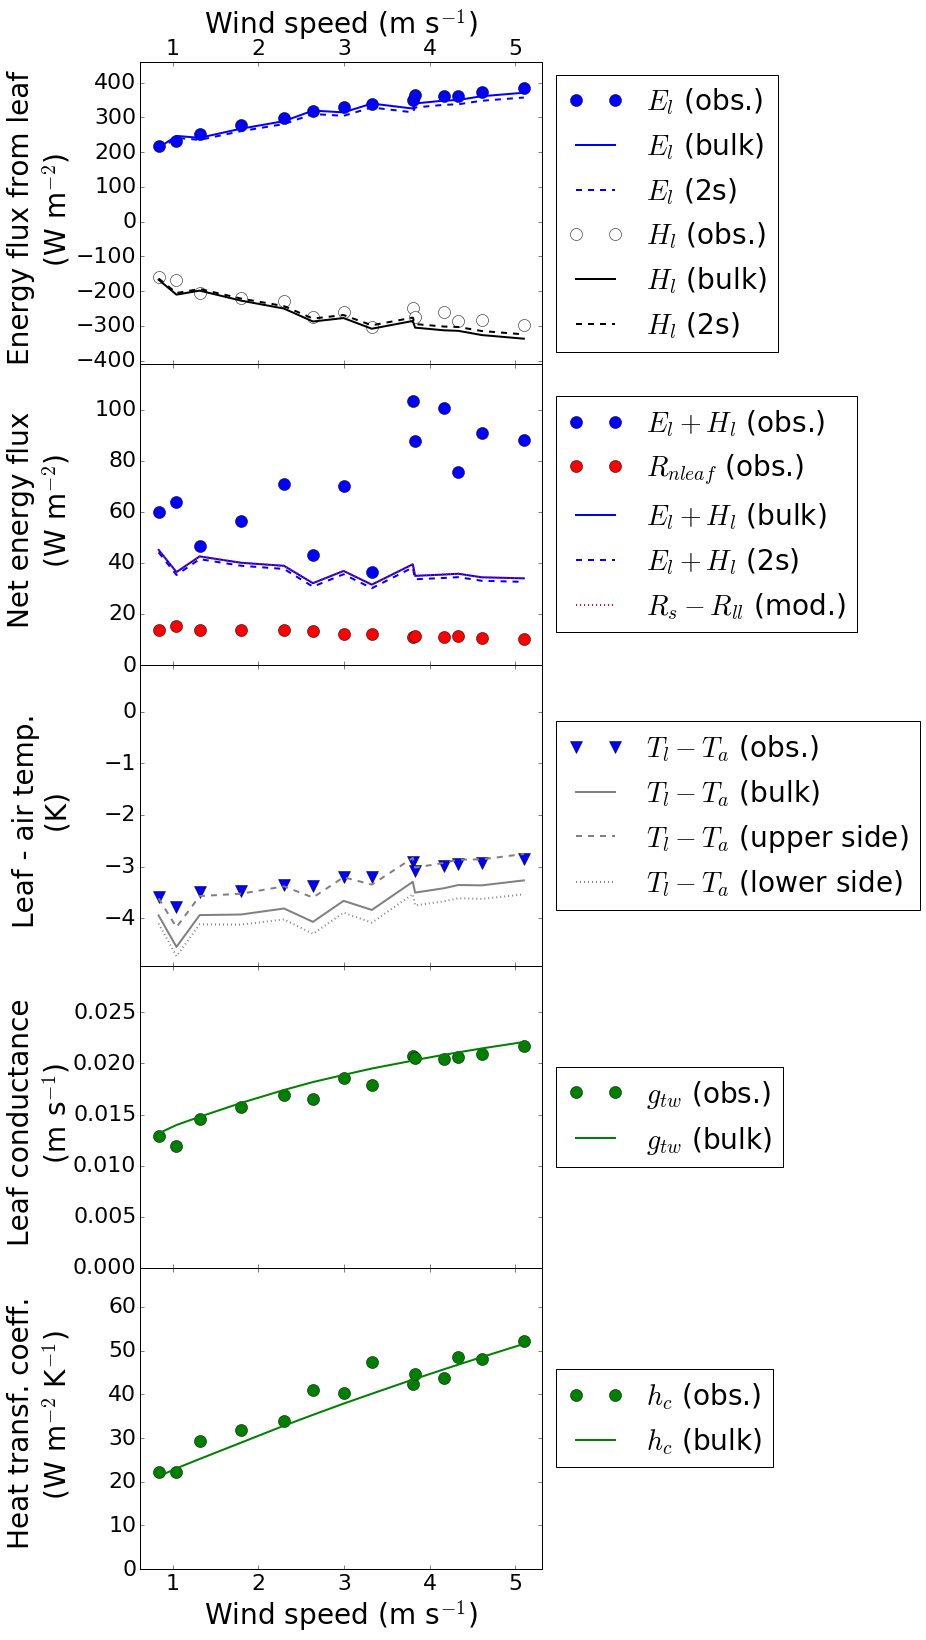

In [40]:
vdict = cdict.copy()
vdict[a_s] = 1
vdict[L_l] = 0.03
vdict[P_a] = 101325.
vdict[R_s] = 0
vdict[Re_c] = 3000.
vdict[k_l] = 0.1  # between 0.268 and 0.573 according to Hays_1975_The_thermal.pdf
vdict[z_l] = 0.0005
#vdict[g_sw] = (0.028+0.051)/2   # According to perforated_foils_LO: range 0.027--0.042
vdict[g_sw] = 0.042
print vdict[g_sw]
results_orig = fun_results(lc_data, vdict, twosides=True)
results1 = results_orig.copy()
list_vars = ['R_s', 'P_wa', 'T_a', 'v_w', 'g_sw']
for var1 in list_vars:
    print var1 + ' = (' + str(min(results1[var1])) + ', ' + str(max(results1[var1])) + ') ' + str(udict[eval(var1)]/eval(var1))

fname = path_figs + '35_vw_klcal_2s_all.eps'
fun_plot_TN(results1, fsize = 14,  alltemps = False, \
        Emods = [('E_l', '(bulk)', '-'), ('2s_E_l', '(2s)', '--')], Hmods = [('H_l', '(bulk)', '-'), ('2s_H_l', '(2s)', '--')], \
        Tmods = [('T_l', '(bulk)', '-'), ('2s_T_lu', '(upper side)', '--'), ('2s_T_ll', '(lower side)', ':')], dpi1=50, fname=fname)

## Leaf 7_1,  Figure A5b in Schymanski et al. (2016, HESSD)


In [41]:
fname1 = 'new_tunnel_chamber_2Tin_leaf.csv'
fname = path_data + fname1
try:
    reader = csv.reader(open(fname, 'rb'), delimiter=',', quotechar='"')
except:
    copyfile(path_data_orig + fname1, fname)
    reader = csv.reader(open(fname, 'rb'), delimiter=',', quotechar='"')

nameslist = reader.next()
unitslist = reader.next()
ncols = len(nameslist)
print ncols
print nameslist
print unitslist
csvdata = []
for row in reader :
    row1 = np.array(row)
    # replacing empty fields by NaN
    row1[row1==''] = 'NaN'
    row = tuple(row1)
    csvdata.append(row)

formatslist = []
for i in srange(len(unitslist)):
    if unitslist[i] == '':
        formatslist.append('S100')
    else:
        formatslist.append('float')
data = np.array(csvdata,dtype = zip(nameslist,formatslist))
data_orig = data.copy()

tabledata = []
tabledata.append(list(nameslist))
tabledata.append(list(unitslist))
for i in srange(len(data)):
    line1 = data[i]
    tabledata.append(list(line1) )
#print tabledata
table(tabledata)

18
['Date', 'Time', 'Inflow rate', 'Tdew humidifier', 'Incoming2 Temp_C(5)', 'Incoming3 Temp_C(6)', 'wall inside Temp_C(3) ', 'wall outside Temp_C(4)', 'chamber air Temp_C(1) ', 'Tl1', 'Tl2', 'TlIR', 'Tlin', 'Fan power', 'FlowMeter out', 'Wind speed', 'Sensirion', 'Comment']
['', '', 'l/min', 'oC', 'oC', 'oC', 'oC', 'oC', 'oC', 'oC', 'oC', 'oC', 'oC', 'W', 'l/min', 'm/s', 'ul/min', '']


Date,Time,Inflow rate,Tdew humidifier,Incoming2 Temp_C(5),Incoming3 Temp_C(6),wall inside Temp_C(3),wall outside Temp_C(4),chamber air Temp_C(1),Tl1,Tl2,TlIR,Tlin,Fan power,FlowMeter out,Wind speed,Sensirion,Comment
,,l/min,oC,oC,oC,oC,oC,oC,oC,oC,oC,oC,W,l/min,m/s,ul/min,
18.02.2014,17:24,,,,,,,,,,,,,,,,"New tunnel with chamber, perforated leaf (7_1) in chamber"
18.02.2014,18:09,,,,,,,,,,,,,,,,NaN
19.02.2014,18:08,,,,,,,,,,,,,,,,lid of TC multiplexer not on!
20.02.2014,11:09,,,,,,,,,,,,,,,,NaN
20.02.2014,13:20,,,,,,,,,,,,,,,,NaN
20.02.2014,13:46,,,,,,,,,,,,,,,,NaN
20.02.2014,14:07,,,,,,,,,,,,,,,,NaN
20.02.2014,14:38,,,,,,,,,,,,,,,,NaN
20.02.2014,14:56,,,,,,,,,,,,,,,,NaN


In [42]:
data.dtype

dtype([('Date', 'S100'), ('Time', 'S100'), ('Inflow rate', '<f8'), ('Tdew humidifier', '<f8'), ('Incoming2 Temp_C(5)', '<f8'), ('Incoming3 Temp_C(6)', '<f8'), ('wall inside Temp_C(3) ', '<f8'), ('wall outside Temp_C(4)', '<f8'), ('chamber air Temp_C(1) ', '<f8'), ('Tl1', '<f8'), ('Tl2', '<f8'), ('TlIR', '<f8'), ('Tlin', '<f8'), ('Fan power', '<f8'), ('FlowMeter out', '<f8'), ('Wind speed', '<f8'), ('Sensirion', '<f8'), ('Comment', 'S100')])

In [43]:
pos_vlow = [3,4,5,6,7,9]
pos_vhigh = [10,11]

R_s = (0.0, 0.0) joule/(R_s*meter^2*second)
P_wa = (168.502255462, 1143.55502295) pascal/P_wa
T_a = (296.05, 296.71) kelvin/T_a
v_w = (0.7, 0.7) meter/(second*v_w)
g_sw = (0.007, 0.007) meter/(g_sw*second)


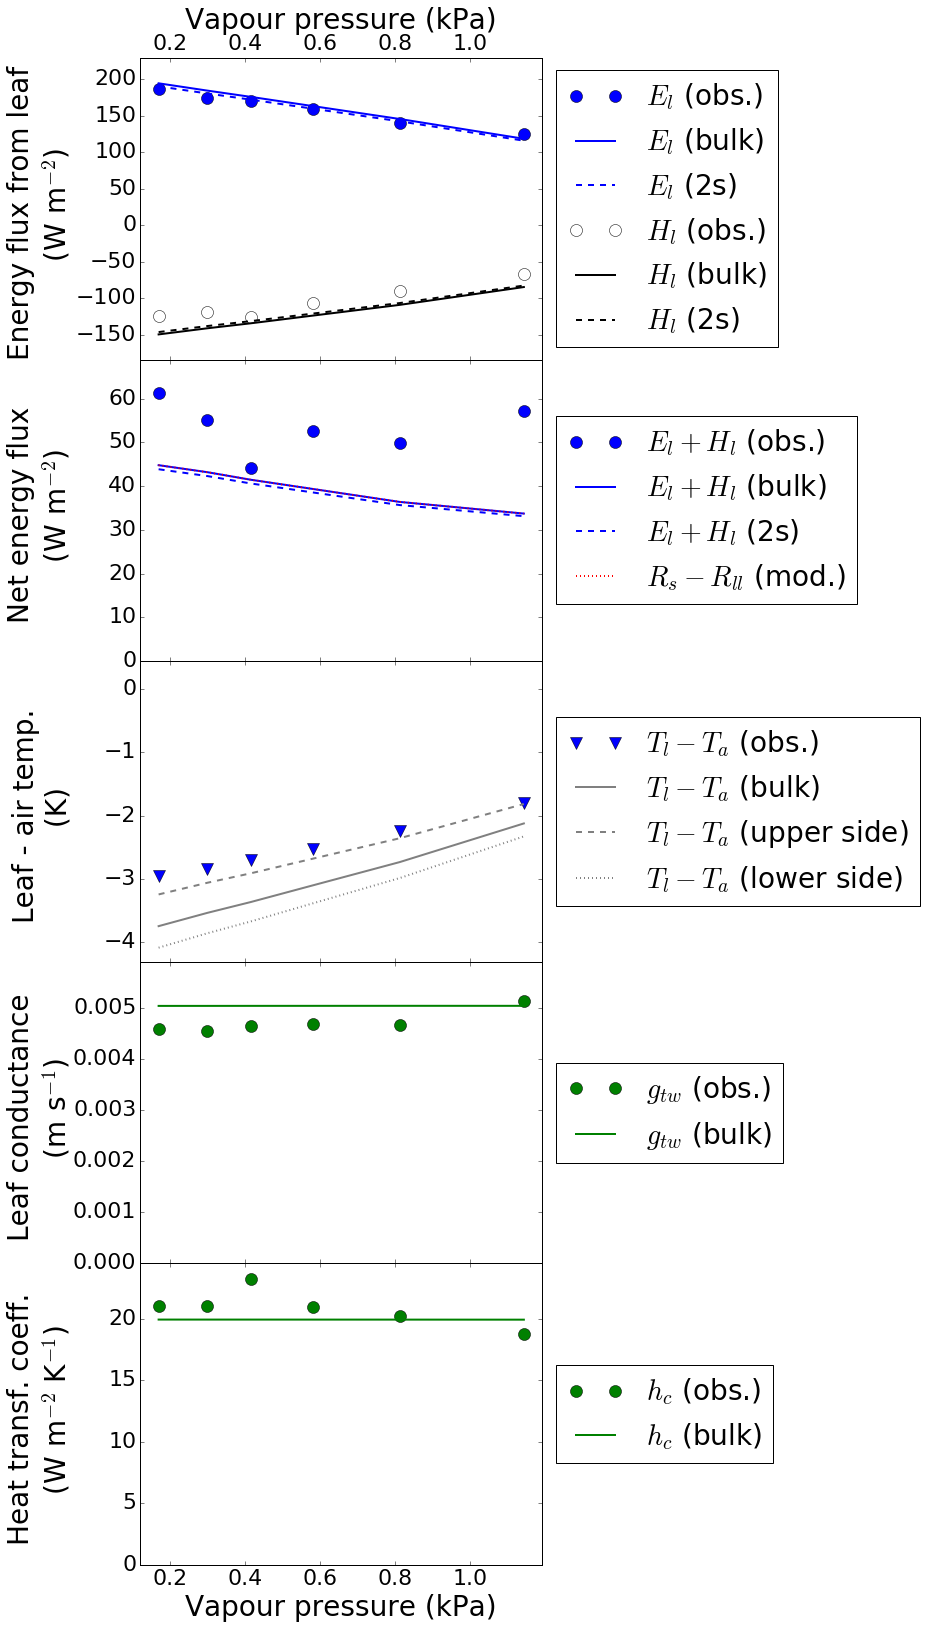

In [44]:
vdict = cdict.copy()
vdict[a_s] = 1
vdict[L_l] = 0.03
vdict[P_a] = 101325.
vdict[R_s] = 0
vdict[Re_c] = 3000.
vdict[k_l] = 0.05  # between 0.268 and 0.573 according to Hays_1975_The_thermal.pdf
vdict[z_l] = 0.0005
vdict[g_sw] = 0.007   # Range: 0.005 to 0.01
ndict = {R_s: '', T_d: 'Tdew humidifier', T_l: 'Tlin', Q_in: 'Fan power', S_a: 'Rn_above_leaf', S_b: 'Rn_below_leaf', S_s: 'Rn_beside_leaf', T_in: 'Incoming2 Temp_C(5)', F_in_v: 'Inflow rate', v_w: 'Wind speed', T_a: 'chamber air Temp_C(1) ', E_lmol: 'Sensirion'}

results_orig = fun_results(data, vdict1=vdict, ndict1=ndict, twosides=True)
results1 = results_orig[pos_vlow]
list_vars = ['R_s', 'P_wa', 'T_a', 'v_w', 'g_sw']
for var1 in list_vars:
    print var1 + ' = (' + str(min(results1[var1])) + ', ' + str(max(results1[var1])) + ') ' + str(udict[eval(var1)]/eval(var1))
fname = path_figs + '7_Pwa_klcal_2s_all.eps'
fun_plot_TN(results1, varname1 = 'P_wa', axeslabel1 = 'Vapour pressure (kPa)', xfac = 1/1000., fsize = 14,  alltemps = False, \
        Emods = [('E_l', '(bulk)', '-'), ('2s_E_l', '(2s)', '--')], Hmods = [('H_l', '(bulk)', '-'), ('2s_H_l', '(2s)', '--')], \
        Tmods = [('T_l', '(bulk)', '-'), ('2s_T_lu', '(upper side)', '--'), ('2s_T_ll', '(lower side)', ':')], dpi1=50, fname=fname)

<p><span style="color: #ff0000;">Even if the observed leaf temperature is 0.7 K above the simulated, observed leaf conductance and $E_l$ are close to simulated, as sensitivity of $E_l$ to $g_{tw}$ is much greater than to $T_l$ at low $g_{sw}$ (see below).Only observed $h_c$ is above the simulated, as expected from the difference in $T_l$.</span></p>

### Comparison of 35 and 7 pores/mm2

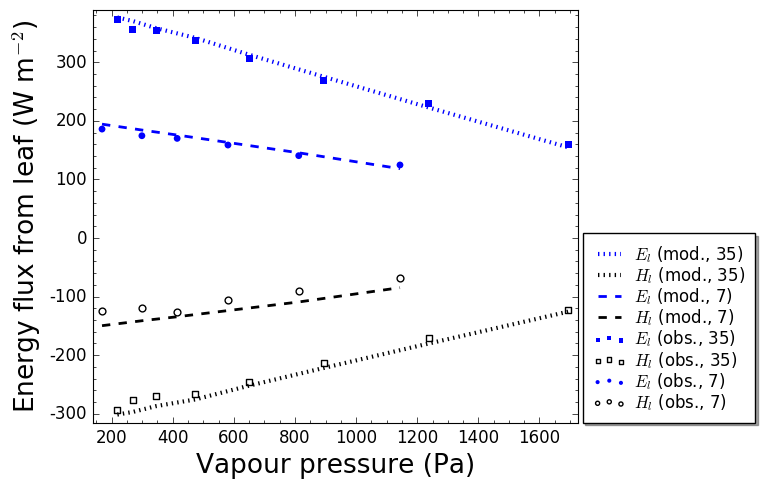

In [45]:
leglength=2
lfsize = 12
axfsize = 18
figsize1 = [6,5]
psize = 24
varname1 = 'P_wa'
axeslabel1 = 'Vapour pressure (Pa)'
Emods = [('E_l', '(mod., 35)', ':')]
Hmods = [('H_l', '(mod., 35)', ':')]
lwidth = 3

# 35 holes data
results2 = results_35.copy()

results2 = np.sort(results2, order = varname1)
pos_vw = srange(len(results2))
xdata = results2[varname1][pos_vw]
Talist = results2['T_a'][pos_vw]

P = list_plot(zip(xdata,results2['Elmeas'][pos_vw]), frame = True, axes = False, plotjoined=False, marker='s', size=psize, legend_label = '$E_l$ (obs., 35)')
for i in srange(len(Emods)):
    tup1 = Emods[i]
    if len(tup1)<4: 
        tup1 = tuple(list(tup1) + ['blue'])
    P += list_plot(zip(xdata,results2[tup1[0]][pos_vw]), color = tup1[3], plotjoined=True, thickness = lwidth, linestyle=tup1[2], marker=None, legend_label = '$E_l$ ' + tup1[1])

    P += list_plot(zip(xdata,results2['Hlmeas'][pos_vw]), marker='s', faceted = True, color = 'white', markeredgecolor = 'black', size=psize, plotjoined=False, legend_label = '$H_l$ (obs., 35)')
for i in srange(len(Hmods)):
    tup1 = Hmods[i]
    if len(tup1)<4: 
        tup1 = tuple(list(tup1) + ['black'])
    P += list_plot(zip(xdata,results2[tup1[0]][pos_vw]), color = tup1[3], plotjoined=True, thickness = lwidth, linestyle=tup1[2], marker=None, legend_label = '$H_l$ ' + tup1[1])


# Now adding 7 pores / mm2
#Emods = [('E_l', '(S-mod.)', '-'), ('El_ball', '(B-mod.)', '--')]
#Hmods = [('H_l', '(S-mod.)', '-'), ('Hl_ball', '(B-mod.)', '--')]
Emods = [('E_l', '(mod., 7)', '--')]
Hmods = [('H_l', '(mod., 7)', '--')]
lwidth = 2

# Sorting array along v_w
results2 = results1.copy()

results2 = np.sort(results2, order = varname1)
pos_vw = srange(len(results2))
xdata = results2[varname1][pos_vw]
Talist = results2['T_a'][pos_vw]

P += list_plot(zip(xdata,results2['Elmeas'][pos_vw]), frame = True, axes = False, plotjoined=False, marker='o', size=psize, legend_label = '$E_l$ (obs., 7)')
for i in srange(len(Emods)):
    tup1 = Emods[i]
    if len(tup1)<4: 
        tup1 = tuple(list(tup1) + ['blue'])
    P += list_plot(zip(xdata,results2[tup1[0]][pos_vw]), color = tup1[3], plotjoined=True, thickness = lwidth, linestyle=tup1[2], marker=None, legend_label = '$E_l$ ' + tup1[1])

    P += list_plot(zip(xdata,results2['Hlmeas'][pos_vw]), marker='o', faceted = True, color = 'white', markeredgecolor = 'black', size=psize, plotjoined=False, legend_label = '$H_l$ (obs., 7)')
for i in srange(len(Hmods)):
    tup1 = Hmods[i]
    if len(tup1)<4: 
        tup1 = tuple(list(tup1) + ['black'])
    P += list_plot(zip(xdata,results2[tup1[0]][pos_vw]), color = tup1[3], plotjoined=True, thickness = lwidth, linestyle=tup1[2], marker=None, legend_label = '$H_l$ ' + tup1[1])



P.axes_labels([axeslabel1, 'Energy flux from leaf (W m$^{-2}$)'])
#P.save(fontsize = fsize, axes_labels_size = axfsize, fig_tight = True, figsize=figsize1, aspect_ratio = 'automatic', legend_font_size = lfsize, legend_loc=(1.01,0), legend_handlelength=leglength, filename = '/home/sschyman/Documents/papers/windtunnel_PM/figures/35_7_Pwa_anal.png') 
P.show(fontsize = lfsize, fig_tight = True, figsize=figsize1, aspect_ratio = 'automatic', legend_font_size = lfsize, legend_handlelength=leglength, legend_loc=(1.01,0.))
#P.show(fontsize = lfsize, axes_labels_size = axfsize, fig_tight = True, figsize=figsize1, aspect_ratio = 'automatic', legend_font_size = lfsize, legend_handlelength=leglength, legend_loc=(1.01,0.))

# Experiments with light

In [46]:
eq_Rs_Rll.show()

-R_ll + R_s == R_d - R_ld - R_lu + R_u

## max_gs, 400 W/m2 irradiance,  Figure 10a in Schymanski et al. (2016, HESSD)

In [47]:
fname = 'exp_maxgs_Rs400_vw.csv'
lc_data_orig = fun_read_csv(fname, lc_timepos = [0, 16, 25, 26, 30, 31])
lc_data = lc_data_orig.copy()
lc_data['water_flow_avg'] = -lc_data_orig['water_flow_avg'] # Making flow positive
lc_data_orig = lc_data.copy()

lc_time,T_in1,T_in2,T_wall_in,T_wall_out,T_outside,T_outside_PT,T_chamber,T_chamber1,T_leaf1,T_leaf2,T_leaf_in,Wind,T_dew,Air_inflow,Air_outflow,nr_time,T_leaf_IR,V_leaf_IR,Rn_above_leaf,Rn_below_leaf,Rn_beside_leaf,RnV_above_leaf,RnV_below_leaf,RnV_beside_leaf,sens_timefirst,sens_timelast,water_flow_avg,water_flow_std,water_flow_n,pow_timefirst,pow_timelast,fan_power_avg,fan_power_std,fan_power_n,Comment...................................................
TS,K,K,K,K,K,Deg C,K,K,K,K,K,m/s,degC,SLPM,SLPM,TS,Deg C,mV,W/m^2,W/m^2,W/m^2,mV,mV,mV,,,ul/min,ul/min,ul/min,TS,TS,W,W,,
2014-05-12 13:32:19,13.08,13.30,23.19,23.18,23.16,26.59,23.17,22.99,21.73,22.80,18.11,5.155,-10.15,4.846,2.292,2014-05-12 13:32:21,17.76,-0.1615,371.1,-19.10,225.6,-0.4441,0.01983,-0.2922,2014-05-12 13:32:09,2014-05-12 13:32:16,-20.85,0.2724,100,2014-05-12 13:31:17,2014-05-12 13:32:16,1.188,0.0000,54,"unlimited gsv, R_s=370, varying v_w"
2014-05-12 14:18:10,13.06,13.24,23.25,23.35,23.34,26.79,23.31,23.11,21.74,22.89,18.35,3.973,-10.09,4.962,2.336,2014-05-12 14:18:10,17.88,-0.1575,375.5,-19.13,231.6,-0.4493,0.01986,-0.3001,2014-05-12 14:17:59,2014-05-12 14:18:06,-19.82,0.4223,100,2014-05-12 14:17:06,2014-05-12 14:18:05,1.188,0.0000,54,"When moving top sensor, Rs is 390 above the edge of leaf, 340 just beside leaf, varying v_w"
2014-05-12 14:18:10,13.06,13.24,23.25,23.35,23.34,26.79,23.31,23.11,21.74,22.89,18.35,3.126,-10.09,4.962,2.336,2014-05-12 14:18:10,17.88,-0.1575,375.0,-19.67,243.0,-0.4488,0.02042,-0.3148,2014-05-12 14:17:59,2014-05-12 14:18:06,-19.82,0.4223,100,2014-05-12 14:17:06,2014-05-12 14:18:05,1.188,0.0000,54,varying v_w
2014-05-12 16:16:31,12.77,12.97,23.42,23.40,23.40,26.75,23.45,23.31,21.75,22.99,19.17,2.138,-10.11,5.447,2.379,2014-05-12 16:16:34,18.64,-0.1307,379.8,-19.36,254.9,-0.4545,0.02010,-0.3302,2014-05-12 16:16:24,2014-05-12 16:16:31,-16.59,0.6848,100,2014-05-12 16:15:32,2014-05-12 16:16:31,1.188,0.0001373,52,varying v_w
2014-05-13 14:14:07,12.43,12.60,22.94,23.10,23.11,26.54,22.97,22.92,20.50,22.85,18.84,2.091,-10.09,5.544,3.058,2014-05-13 14:14:09,18.68,-0.1292,374.8,-18.97,259.1,-0.4486,0.01970,-0.3357,2014-05-13 14:13:59,2014-05-13 14:14:06,-17.50,0.2599,100,2014-05-13 14:13:08,2014-05-13 14:14:06,1.195,0.0006326,53,"new day, Rs=394 at edge of leaf, 330 just beside, but above BL, outside T had just gone up but inside stable, varying v_w"
2014-05-13 14:44:07,12.28,12.44,23.20,23.10,23.08,26.30,23.21,23.28,21.28,23.22,20.56,0.7194,-10.08,5.847,3.133,2014-05-13 14:44:07,20.27,-0.07185,384.2,-17.78,284.7,-0.4598,0.01846,-0.3689,2014-05-13 14:43:56,2014-05-13 14:44:03,-13.52,0.2529,100,2014-05-13 14:43:05,2014-05-13 14:44:04,1.195,0.0004978,53,varying v_w
2014-05-13 15:39:22,12.51,12.68,23.26,23.14,23.12,26.46,23.28,23.26,20.89,23.17,19.62,1.249,-10.10,5.651,3.042,2014-05-13 15:39:25,19.34,-0.1057,380.0,-18.90,268.9,-0.4548,0.01962,-0.3483,2014-05-13 15:39:14,2014-05-13 15:39:21,-15.70,0.1998,100,2014-05-13 15:38:22,2014-05-13 15:39:21,1.194,0.0004736,53,"T_w_out went down when opening the door, stable and equal to T_w_in before, varying v_w"
2014-05-13 16:31:52,12.36,12.52,22.95,23.02,23.01,26.26,22.98,22.94,20.56,22.86,19.08,1.708,-10.08,5.740,3.068,2014-05-13 16:31:53,19.00,-0.1177,375.4,-19.11,264.1,-0.4493,0.01984,-0.3421,2014-05-13 16:31:44,2014-05-13 16:31:51,-16.62,0.2411,100,2014-05-13 16:30:52,2014-05-13 16:31:51,1.194,0.0004796,53,"not quite steady-state, as both T_win and T_wout still decreasing, varying v_w"
2014-05-14 11:25:40,12.44,12.61,22.58,22.74,22.74,26.06,22.61,22.52,20.17,22.43,18.32,2.837,-10.08,5.360,-2.438,2014-05-14 11:25:42,18.65,-0.1303,374.1,-19.12,258.2,-0.4477,0.01985,-0.3345,2014-05-14 11:25:31,2014-05-14 11:25:38,-18.64,0.3499,100,2014-05-14 11:24:38,2014-05-14 11:25:37,1.149,0.0000,54,"T_win constant while T_wout varies, varying v_w"


R_s = (371.1, 384.7) joule/(R_s*meter^2*second)
P_wa = (521.148378386, 802.717535554) pascal/P_wa
T_a = (295.76, 296.6) kelvin/T_a
v_w = (0.7194, 5.155) meter/(second*v_w)
g_sw = (999.0, 999.0) meter/(g_sw*second)


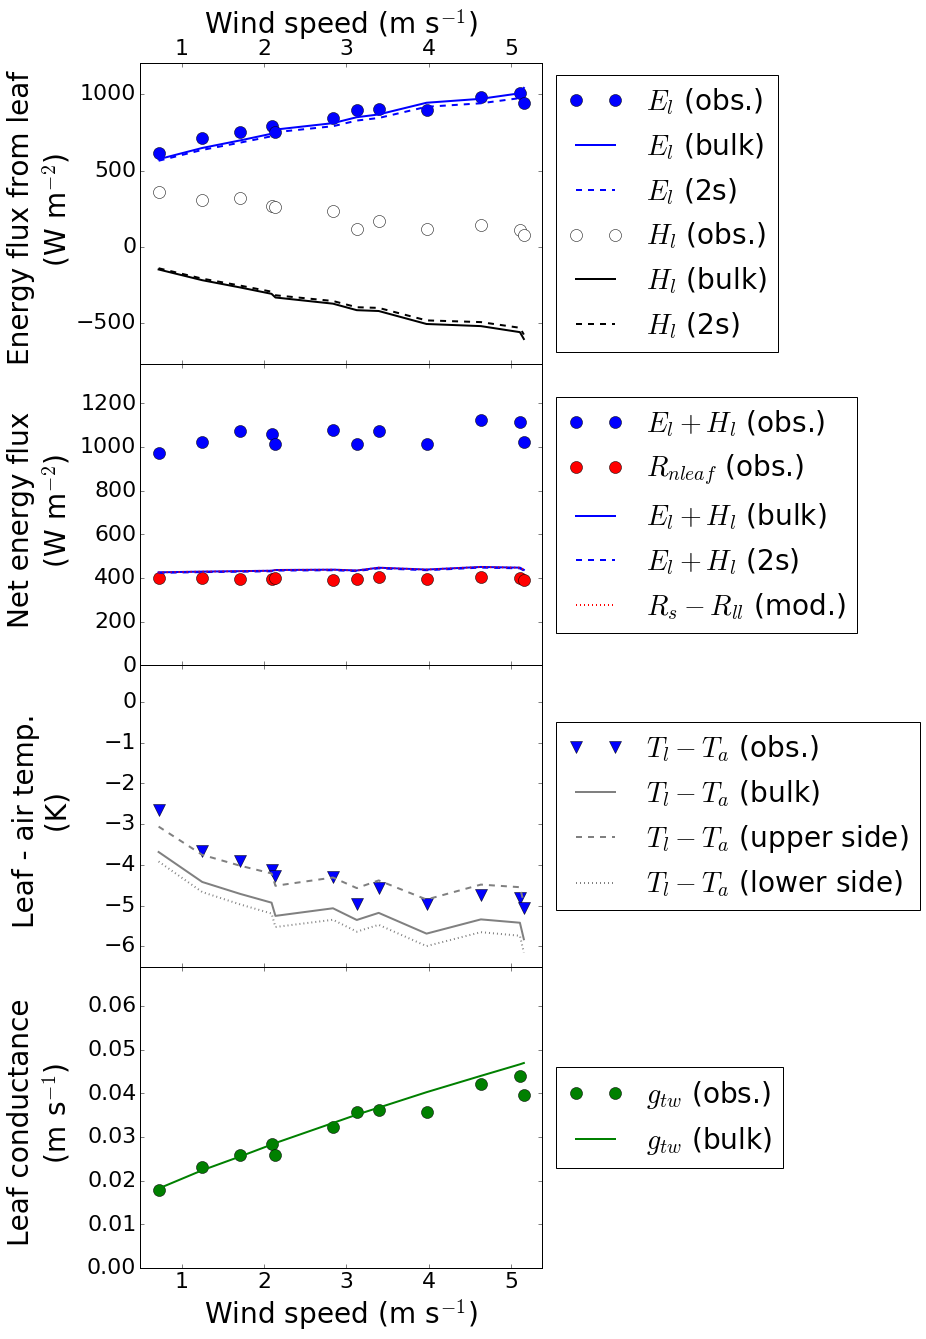

In [48]:
vdict = cdict.copy()
vdict[a_s] = 1
vdict[L_l] = 0.03
vdict[P_a] = 101325.
vdict[Re_c] = 3000.
vdict[k_l] = 0.27  # between 0.268 and 0.573 according to Hays_1975_The_thermal.pdf
vdict[z_l] = 0.0005

vdict[g_sw] = 999
#vdict[R_d] = 350
ndict = {R_s: 'Rn_above_leaf'}
results_orig = fun_results(lc_data, vdict, ndict1=ndict, twosides=True)
results1 = results_orig.copy()
list_vars = ['R_s', 'P_wa', 'T_a', 'v_w', 'g_sw']
for var1 in list_vars:
    print var1 + ' = (' + str(min(results1[var1])) + ', ' + str(max(results1[var1])) + ') ' + str(udict[eval(var1)]/eval(var1))
fname = path_figs + 'maxgs_vw_Rs350_klcal_2s_all.eps'
fun_plot_TN(results1, fsize = 14,  alltemps = False, hccomp=False,\
        Emods = [('E_l', '(bulk)', '-'), ('2s_E_l', '(2s)', '--')], Hmods = [('H_l', '(bulk)', '-'), ('2s_H_l', '(2s)', '--')], \
        Tmods = [('T_l', '(bulk)', '-'), ('2s_T_lu', '(upper side)', '--'), ('2s_T_ll', '(lower side)', ':')], dpi1=50, fname=fname)   

**Both observed $R_{nleaf}$ and modelled $R_s - R_{ll}$ are well above the measured $R_s$ of 380-380 W m$^{-2}$. This is because the leaf is colder than the surrounding air, despite the irradiance, and absorbs radiative heat. As before, the emitted longwave is lower in the measurements than in the calculations by a factor of 2:**

In [49]:
print results1['R_ll']
print 2*results1['Rn_below_leaf']

[-66.79455469 -63.69420353 -59.94529105 -57.25009905 -58.99117613
 -42.23206142 -49.78036043 -56.44617497 -64.55474572 -63.35658665
 -66.36692692 -66.61249155]
[-38.2  -38.26 -39.34 -38.72 -37.94 -35.56 -37.8  -38.22 -38.24 -37.74
 -38.34 -38.24]


## 7 holes/mm2, 500 W/m2 light,  Figure 10b in Schymanski et al. (2016, HESSD)
<p> </p>
<pre class="shrunk">min/max:
gsp: (0.012254157, 0.014780151)
gsw: (0.00519383, 0.0059423419)
gsw_r0: (0.0074208532, 0.0086463923)
gsw_r0_S: (0.0087905126, 0.010359369)
gsw_AO: (0.0040818779, 0.0046200179)

BUMP:
gsp: (0.0079768673, 0.0099597964)
gsw: (0.0036078144, 0.0044655325)
gsw_r0: (0.0050318656, 0.0062556397)
gsw_r0_S: (0.0058744419, 0.0073222672)
gsw_AO: (0.0029048966, 0.0035467658)</pre>
<p>$g_{sv}$ in the range of 0.005-0.0073 (see perforated_foils_LO.sws, 7 holes/mm2)</p>

In [50]:
fname = 'exp_7_2_Rs500_vw.csv'
lc_data_orig = fun_read_csv(fname, lc_timepos = [0, 16, 25, 26, 30, 31])
lc_data = lc_data_orig.copy()
lc_data['water_flow_avg'] = -lc_data_orig['water_flow_avg'] # Making flow positive
lc_data_orig = lc_data.copy()

lc_time,T_in1,T_in2,T_wall_in,T_wall_out,T_outside,T_outside_PT,T_chamber,T_chamber1,T_leaf1,T_leaf2,T_leaf_in,Wind,T_dew,Air_inflow,Air_outflow,nr_time,T_leaf_IR,V_leaf_IR,Rn_above_leaf,Rn_below_leaf,Rn_beside_leaf,RnV_above_leaf,RnV_below_leaf,RnV_beside_leaf,sens_timefirst,sens_timelast,water_flow_avg,water_flow_std,water_flow_n,pow_timefirst,pow_timelast,fan_power_avg,fan_power_std,fan_power_n,Comment...................................................
TS,K,K,K,K,K,Deg C,K,K,K,K,K,m/s,degC,SLPM,SLPM,TS,Deg C,mV,W/m^2,W/m^2,W/m^2,mV,mV,mV,,,ul/min,ul/min,ul/min,TS,TS,W,W,,
2014-04-24 12:20:42,11.33,11.48,22.75,22.75,22.75,26.18,22.71,22.78,22.88,22.89,24.17,5.239,-10.09,7.536,3.664,2014-04-24 12:20:44,22.63,0.01611,540.8,-3.318,362.9,-0.6472,0.003458,-0.4702,2014-04-24 12:20:35,2014-04-24 12:20:42,-7.476,0.1281,100,2014-04-24 12:19:43,2014-04-24 12:20:42,1.243,0.0004275,54,"Leaf 7-2, R_s=500, varying v_w, light source: Fiber lite PL-800, not fully reaching Rn_beside_leaf"
2014-04-24 13:14:51,11.37,11.53,22.87,22.85,22.82,26.14,22.93,22.98,23.12,23.14,24.51,3.990,-10.08,7.453,3.636,2014-04-24 13:14:55,22.77,0.02110,532.0,-3.465,358.1,-0.6366,0.003610,-0.4641,2014-04-24 13:14:47,2014-04-24 13:14:54,-7.262,0.1002,100,2014-04-24 13:13:55,2014-04-24 13:14:54,1.243,0.0003552,54,"Leaf 7-2, R_s=500, varying v_w"
2014-04-24 14:24:45,11.43,11.61,22.98,22.96,22.92,26.30,23.02,23.16,23.42,23.40,25.11,3.090,-10.10,7.437,3.663,2014-04-24 14:24:47,23.07,0.03283,541.5,-3.292,379.7,-0.6481,0.003431,-0.4920,2014-04-24 14:24:39,2014-04-24 14:24:46,-7.256,0.08109,100,2014-04-24 14:23:47,2014-04-24 14:24:46,1.243,0.0000,53,"Leaf 7-2, R_s=500, varying v_w"
2014-04-24 14:55:03,11.56,11.71,23.10,23.06,23.07,26.55,23.10,23.38,23.87,23.76,26.01,1.931,-10.09,7.240,3.564,2014-04-24 14:55:06,23.44,0.04701,538.4,-3.794,397.3,-0.6443,0.003953,-0.5148,2014-04-24 14:54:57,2014-04-24 14:55:04,-7.211,0.1762,100,2014-04-24 14:54:05,2014-04-24 14:55:04,1.243,0.0003168,53,"Leaf 7-2, R_s=500, varying v_w, closed lid of TC-multiplexer"
2014-04-24 16:06:00,11.72,11.86,23.37,23.23,23.24,26.67,23.37,23.95,24.99,24.85,27.79,0.7260,-10.07,7.039,3.494,2014-04-24 16:06:04,24.32,0.08090,547.9,-3.250,415.7,-0.6558,0.003387,-0.5386,2014-04-24 16:05:54,2014-04-24 16:06:01,-6.924,0.1938,100,2014-04-24 16:05:03,2014-04-24 16:06:01,1.243,0.0004056,53,"Leaf 7-2, R_s=500, varying v_w"
2014-04-24 17:10:39,11.63,11.78,23.27,23.22,23.20,26.55,23.30,23.70,24.47,24.34,27.07,1.136,-10.08,7.225,3.531,2014-04-24 17:10:41,23.91,0.06495,554.4,-2.676,408.1,-0.6635,0.002791,-0.5288,2014-04-24 17:10:32,2014-04-24 17:10:39,-6.814,0.1089,100,2014-04-24 17:09:40,2014-04-24 17:10:39,1.243,0.0002642,53,"Leaf 7-2, R_s=500, varying v_w"
2014-04-24 18:03:42,11.47,11.61,23.26,23.24,23.22,26.55,23.22,23.32,23.43,23.45,24.97,4.709,-10.09,7.549,3.726,2014-04-24 18:03:42,22.77,0.02109,543.6,-3.100,364.2,-0.6505,0.003231,-0.4719,2014-04-24 18:03:34,2014-04-24 18:03:41,-6.617,0.3075,100,2014-04-24 18:02:43,2014-04-24 18:03:42,1.243,0.0005462,53,"Leaf 7-2, R_s=500, varying v_w"


R_s = (532.0, 554.4) joule/(R_s*meter^2*second)
P_wa = (341.343007329, 356.31124279) pascal/P_wa
T_a = (295.86, 296.52) kelvin/T_a
v_w = (0.726, 5.239) meter/(second*v_w)
g_sw = (0.008, 0.008) meter/(g_sw*second)


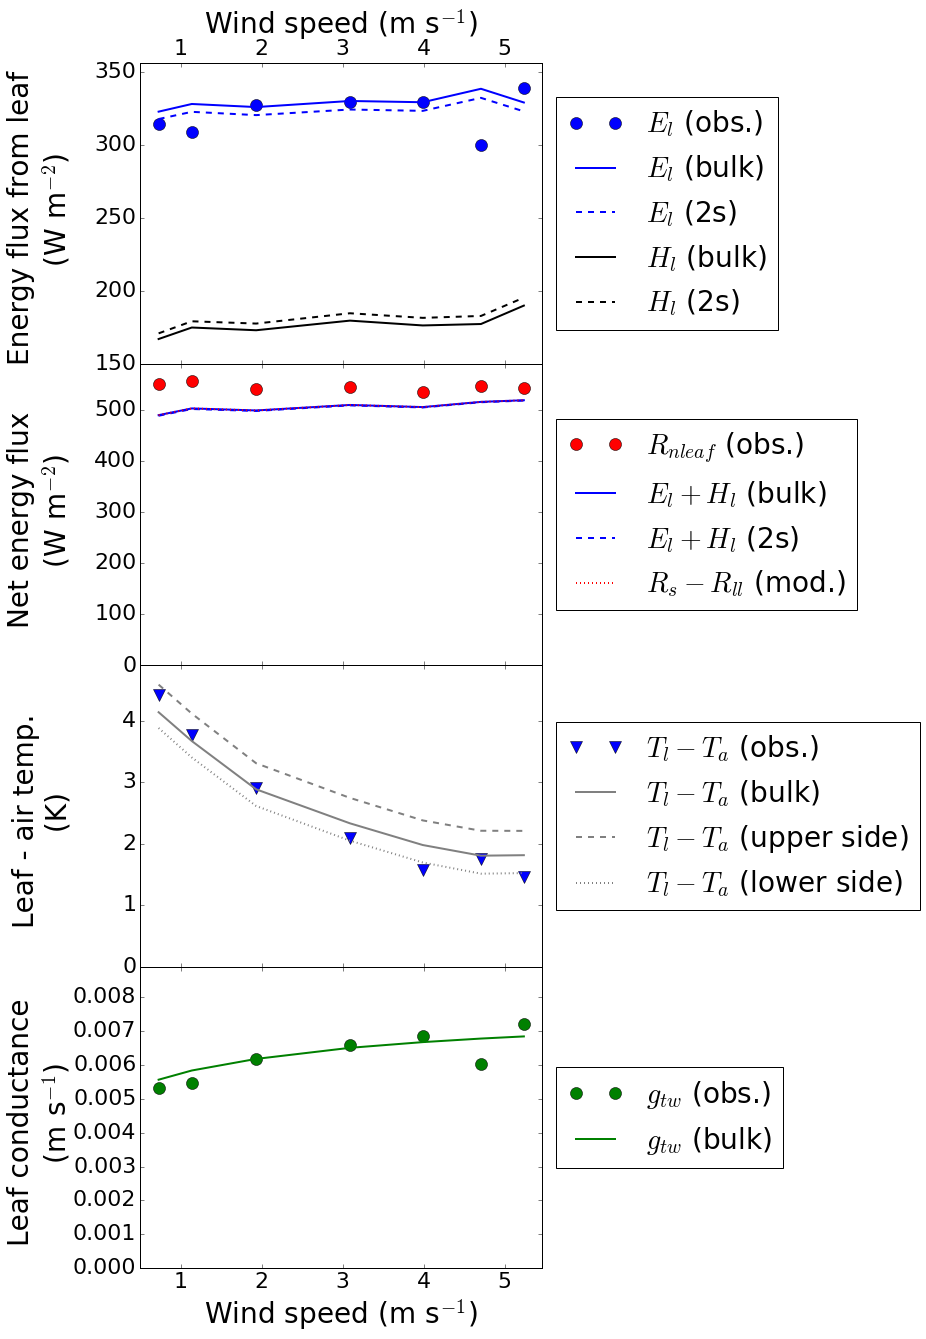

In [51]:
vdict = cdict.copy()
vdict[a_s] = 1
vdict[L_l] = 0.03
vdict[P_a] = 101325.
vdict[R_s] = 0
vdict[Re_c] = 3000.
vdict[k_l] = 0.3 # between 0.268 and 0.573 according to Hays_1975_The_thermal.pdf
vdict[z_l] = 0.0005
vdict[g_sw] = 0.008
#vdict1[R_d] = 550
ndict = {R_s: 'Rn_above_leaf'}
results_orig = fun_results(lc_data, vdict, ndict1=ndict, twosides=True)

results1 = results_orig.copy()
list_vars = ['R_s', 'P_wa', 'T_a', 'v_w', 'g_sw']
for var1 in list_vars:
    print var1 + ' = (' + str(min(results1[var1])) + ', ' + str(max(results1[var1])) + ') ' + str(udict[eval(var1)]/eval(var1))
fname = path_figs + '7_vw_Rs550_klcal_2s_all.eps'
fun_plot_TN(results1, fsize = 14,  alltemps = False, hccomp=False, Hobs=False,\
        Emods = [('E_l', '(bulk)', '-'), ('2s_E_l', '(2s)', '--')], Hmods = [('H_l', '(bulk)', '-'), ('2s_H_l', '(2s)', '--')], \
        Tmods = [('T_l', '(bulk)', '-'), ('2s_T_lu', '(upper side)', '--'), ('2s_T_ll', '(lower side)', ':')], dpi1=50, fname=fname)       

<p><span style="color: #ff0000;">The two low outliers were the last point measured, so it could be that the filter paper started drying out towards the end.</span></p>